In [3]:
# Run this cell first to install required packages
# Uncomment the lines below if packages are not installed

!pip install pandas numpy requests matplotlib seaborn scipy
!pip install yfinance 
!pip install ta-lib  

print("✅ Package installation cell ready!")
print("Uncomment the pip install lines above if you need to install packages")

Uncomment the pip install lines above if you need to install packages

   ---------------------------------------- 0.0/882.8 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/882.8 kB ? eta -:--:--
   ----------------------- ---------------- 524.3/882.8 kB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 882.8/882.8 kB 1.9 MB/s eta 0:00:00

   ---------------------------------------- 3/3 [ta-lib]



In [2]:
import pandas as pd
import numpy as np
import requests
import zipfile
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# For real data
try:
    import yfinance as yf
    YFINANCE_AVAILABLE = True
    print("✅ yfinance available for real data")
except ImportError:
    YFINANCE_AVAILABLE = False
    print("⚠️ yfinance not available, will use sample data")

# For plotting and analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Get current date for data range
TODAY = datetime.now().strftime('%Y-%m-%d')
START_DATE = "2020-01-01"

print(f"✅ All libraries imported successfully!")
print(f"📅 Data range: {START_DATE} to {TODAY}")

✅ yfinance available for real data
✅ All libraries imported successfully!
📅 Data range: 2020-01-01 to 2025-08-09


In [3]:
# Configuration - Update this path to match your system
SYMBOL = "GBPJPY"
DATA_DIR = "C:/Users/enjas/Desktop/Tradingnew/data"
RAW_DIR = os.path.join(DATA_DIR, "raw")
PROCESSED_DIR = os.path.join(DATA_DIR, "processed")

# Create directories
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)

# Data range configuration
START_DATE = "2020-01-01"
END_DATE = datetime.now().strftime('%Y-%m-%d')

print(f"✅ Data directories created:")
print(f"   Raw data: {RAW_DIR}")
print(f"   Processed data: {PROCESSED_DIR}")
print(f"   Working symbol: {SYMBOL}")
print(f"📅 Data range: {START_DATE} to {END_DATE}")
print(f"📊 Total days: {(datetime.now() - datetime.strptime(START_DATE, '%Y-%m-%d')).days}")

✅ Data directories created:
   Raw data: C:/Users/enjas/Desktop/Tradingnew/data\raw
   Processed data: C:/Users/enjas/Desktop/Tradingnew/data\processed
   Working symbol: GBPJPY
📅 Data range: 2020-01-01 to 2025-08-09
📊 Total days: 2047


In [4]:
def download_real_forex_data(symbol="GBPJPY=X", start_date="2020-01-01", end_date=None):
    """Download real forex data using yfinance"""
    if not YFINANCE_AVAILABLE:
        return None
    
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')
    
    try:
        print(f"📡 Downloading real {symbol} data from Yahoo Finance...")
        print(f"📅 Date range: {start_date} to {end_date}")
        
        # Download daily data first
        ticker = yf.Ticker(symbol)
        data = ticker.history(start=start_date, end=end_date, interval="1d")
        
        if data.empty:
            print("❌ No data received from Yahoo Finance")
            return None
        
        # Clean column names and add volume/spread
        data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        
        # Add realistic spread data (GBP/JPY typical spread 2-5 pips)
        np.random.seed(42)
        data['Extra_1'] = np.random.uniform(2.0, 5.0, len(data))
        
        # Ensure proper OHLC logic
        data = data[data['High'] >= data[['Open', 'Close']].max(axis=1)]
        data = data[data['Low'] <= data[['Open', 'Close']].min(axis=1)]
        
        print(f"✅ Downloaded {len(data)} days of real data")
        print(f"📊 Date range: {data.index.min()} to {data.index.max()}")
        
        return data
        
    except Exception as e:
        print(f"❌ Error downloading real data: {e}")
        return None

def create_sample_data(timeframe, start_date="2020-01-01", end_date=None):
    """Create realistic sample GBPJPY data until today"""
    
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')
    
    # Frequency mapping
    freq_map = {
        "15m": "15T", "30m": "30T", "1h": "1H", 
        "4h": "4H", "1d": "1D"
    }
    
    # Generate date range
    date_range = pd.date_range(
        start=start_date, end=end_date, 
        freq=freq_map.get(timeframe, "1H")
    )
    
    print(f"   📊 Creating {len(date_range)} {timeframe} candles from {start_date} to {end_date}")
    
    # Generate realistic GBPJPY price movements based on historical patterns
    np.random.seed(42)  # For reproducibility
    
    # Use realistic base price and volatility patterns
    base_price = 150.0  # Starting around current levels
    n_periods = len(date_range)
    
    # Create more realistic price series with:
    # 1. Long-term trends
    # 2. Medium-term cycles  
    # 3. Short-term volatility
    # 4. Regime changes
    
    # Long-term trend (5-year cycle)
    long_trend = np.sin(np.linspace(0, 4*np.pi, n_periods)) * 0.1
    
    # Medium-term cycles (quarterly/monthly)
    medium_cycle = np.sin(np.linspace(0, 20*np.pi, n_periods)) * 0.05
    
    # Volatility clustering (GARCH-like)
    volatility = np.zeros(n_periods)
    volatility[0] = 0.002
    for i in range(1, n_periods):
        volatility[i] = 0.0001 + 0.85 * volatility[i-1] + 0.1 * np.random.normal(0, 0.0005)**2
    
    # Generate returns with varying volatility
    returns = []
    for i in range(n_periods):
        vol = max(volatility[i], 0.0005)  # Minimum volatility
        trend_component = long_trend[i] + medium_cycle[i]
        noise = np.random.normal(0, vol)
        returns.append(trend_component + noise)
    
    # Create price series
    log_prices = np.cumsum(returns)
    prices = base_price * np.exp(log_prices)
    
    # Generate OHLC data with realistic intrabar movements
    data = []
    for i, price in enumerate(prices):
        if i == 0:
            open_price = price
        else:
            open_price = data[i-1]['Close']
        
        # Use current volatility for intrabar range
        current_vol = volatility[i] if i < len(volatility) else 0.002
        range_size = open_price * current_vol * np.random.uniform(0.5, 2.0)
        
        # Generate high/low with bias towards direction
        direction_bias = (price - open_price) / open_price if open_price != 0 else 0
        
        if direction_bias > 0:  # Bullish bias
            high = open_price + range_size * np.random.uniform(0.6, 1.0)
            low = open_price - range_size * np.random.uniform(0.2, 0.6)
        else:  # Bearish bias
            high = open_price + range_size * np.random.uniform(0.2, 0.6)
            low = open_price - range_size * np.random.uniform(0.6, 1.0)
        
        close = price
        
        # Ensure OHLC logic
        high = max(open_price, high, close, low + 0.001)
        low = min(open_price, low, close, high - 0.001)
        
        # Volume patterns (higher during certain hours, news events)
        hour = date_range[i].hour if hasattr(date_range[i], 'hour') else 12
        
        # Volume based on session (London/NY overlap = higher volume)
        if 13 <= hour <= 17:  # London/NY overlap
            base_volume = np.random.randint(3000, 12000)
        elif 8 <= hour <= 17:  # London session
            base_volume = np.random.randint(2000, 8000)
        elif 21 <= hour or hour <= 6:  # Asia session
            base_volume = np.random.randint(1000, 5000)
        else:  # Off hours
            base_volume = np.random.randint(500, 2000)
        
        # Add volatility-based volume boost
        vol_multiplier = 1 + (current_vol / 0.002)
        volume = int(base_volume * vol_multiplier)
        
        # Realistic GBP/JPY spread (2-6 pips, wider during low liquidity)
        if 22 <= hour or hour <= 6:  # Low liquidity hours
            spread = np.random.uniform(3.5, 6.0)
        else:  # Normal hours
            spread = np.random.uniform(2.0, 4.5)
        
        data.append({
            'Open': round(open_price, 3),
            'High': round(high, 3),
            'Low': round(low, 3),
            'Close': round(close, 3),
            'Volume': volume,
            'Extra_1': round(spread, 1)
        })
    
    df = pd.DataFrame(data, index=date_range)
    
    print(f"   ✅ Generated realistic data: {len(df)} rows")
    print(f"   📈 Price range: {df['Close'].min():.3f} - {df['Close'].max():.3f}")
    print(f"   📊 Avg volume: {df['Volume'].mean():.0f}")
    print(f"   💰 Avg spread: {df['Extra_1'].mean():.2f} pips")
    
    return df

def download_forex_data(timeframes=["15m", "30m", "1h"]):
    """Download or create forex data with current date range"""
    print("🚀 Starting data acquisition...")
    print(f"📅 Target date range: {START_DATE} to {END_DATE}")
    
    downloaded_data = {}
    
    # Try to get real daily data first
    real_daily_data = download_real_forex_data("GBPJPY=X", START_DATE, END_DATE)
    
    for tf in timeframes:
        print(f"\n📊 Processing {tf} timeframe...")
        
        if real_daily_data is not None and tf == "1d":
            # Use real daily data
            downloaded_data[tf] = real_daily_data
            print(f"   ✅ Using real daily data: {len(real_daily_data)} rows")
        else:
            # Create sample data for intraday timeframes
            df = create_sample_data(tf, START_DATE, END_DATE)
            downloaded_data[tf] = df
    
    print(f"\n✅ Data acquisition completed for {len(timeframes)} timeframes!")
    return downloaded_data

# Execute data download/creation
print("🚀 Starting enhanced data acquisition process...")
timeframe_data = download_forex_data(["15m", "30m", "1h"])
print("✅ Data acquisition completed!")

# Display summary
for tf, df in timeframe_data.items():
    print(f"📊 {tf}: {len(df)} rows from {df.index.min()} to {df.index.max()}")

🚀 Starting enhanced data acquisition process...
🚀 Starting data acquisition...
📅 Target date range: 2020-01-01 to 2025-08-09
📡 Downloading real GBPJPY=X data from Yahoo Finance...
📅 Date range: 2020-01-01 to 2025-08-09
❌ Error downloading real data: Length mismatch: Expected axis has 7 elements, new values have 5 elements

📊 Processing 15m timeframe...
   📊 Creating 196513 15m candles from 2020-01-01 to 2025-08-09
   ✅ Generated realistic data: 196513 rows
   📈 Price range: 134.250 - inf
   📊 Avg volume: 5417
   💰 Avg spread: 3.81 pips

📊 Processing 30m timeframe...
   📊 Creating 98257 30m candles from 2020-01-01 to 2025-08-09
   ✅ Generated realistic data: 98257 rows
   📈 Price range: 149.697 - inf
   📊 Avg volume: 5410
   💰 Avg spread: 3.81 pips

📊 Processing 1h timeframe...
   📊 Creating 49129 1h candles from 2020-01-01 to 2025-08-09
   ✅ Generated realistic data: 49129 rows
   📈 Price range: 149.054 - inf
   📊 Avg volume: 5425
   💰 Avg spread: 3.81 pips

✅ Data acquisition complete

In [6]:
# Fixed Cell 4: Enhanced Data Download Functions (Corrected)

def download_real_forex_data(symbol="GBPJPY=X", start_date="2020-01-01", end_date=None):
    """Download real forex data using yfinance - FIXED VERSION"""
    if not YFINANCE_AVAILABLE:
        return None
    
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')
    
    try:
        print(f"📡 Downloading real {symbol} data from Yahoo Finance...")
        print(f"📅 Date range: {start_date} to {end_date}")
        
        # Download daily data
        ticker = yf.Ticker(symbol)
        data = ticker.history(start=start_date, end=end_date, interval="1d")
        
        if data.empty:
            print("❌ No data received from Yahoo Finance")
            return None
        
        print(f"📊 Raw data shape: {data.shape}")
        print(f"📊 Raw columns: {list(data.columns)}")
        
        # Handle different column structures from yfinance
        if len(data.columns) >= 5:
            # Keep only OHLCV columns and rename properly
            data = data.iloc[:, :5].copy()  # Take first 5 columns
            data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        else:
            print("❌ Insufficient columns in downloaded data")
            return None
        
        # Remove any rows with NaN or infinite values
        data = data.replace([np.inf, -np.inf], np.nan)
        data = data.dropna()
        
        if data.empty:
            print("❌ No valid data after cleaning")
            return None
        
        # Add realistic spread data (GBP/JPY typical spread 2-5 pips)
        np.random.seed(42)
        data['Extra_1'] = np.random.uniform(2.0, 5.0, len(data))
        
        # Ensure proper OHLC logic
        data = data[data['High'] >= data[['Open', 'Close']].max(axis=1)]
        data = data[data['Low'] <= data[['Open', 'Close']].min(axis=1)]
        
        # Final validation
        if data.empty:
            print("❌ No data after OHLC validation")
            return None
        
        print(f"✅ Downloaded {len(data)} days of real data")
        print(f"📊 Date range: {data.index.min()} to {data.index.max()}")
        print(f"📈 Price range: {data['Close'].min():.3f} - {data['Close'].max():.3f}")
        
        return data
        
    except Exception as e:
        print(f"❌ Error downloading real data: {e}")
        print("📝 Falling back to sample data generation")
        return None

def create_sample_data(timeframe, start_date="2020-01-01", end_date=None):
    """Create realistic sample GBPJPY data - FIXED VERSION"""
    
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')
    
    # Frequency mapping
    freq_map = {
        "15m": "15T", "30m": "30T", "1h": "1H", 
        "4h": "4H", "1d": "1D"
    }
    
    # Generate date range
    date_range = pd.date_range(
        start=start_date, end=end_date, 
        freq=freq_map.get(timeframe, "1H")
    )
    
    print(f"   📊 Creating {len(date_range)} {timeframe} candles from {start_date} to {end_date}")
    
    # Generate realistic GBPJPY price movements - FIXED INFINITE VALUES
    np.random.seed(42)  # For reproducibility
    
    # Use realistic base price and constrained volatility
    base_price = 150.0  # Starting around current levels
    n_periods = len(date_range)
    
    # Create constrained price series to avoid infinite values
    # 1. Long-term trend (5-year cycle) - BOUNDED
    long_trend = np.sin(np.linspace(0, 4*np.pi, n_periods)) * 0.05  # Reduced amplitude
    
    # 2. Medium-term cycles - BOUNDED
    medium_cycle = np.sin(np.linspace(0, 20*np.pi, n_periods)) * 0.02  # Reduced amplitude
    
    # 3. Constrained volatility to prevent infinite values
    volatility = np.full(n_periods, 0.001)  # Start with constant low volatility
    for i in range(1, min(1000, n_periods)):  # Limit volatility calculation to prevent overflow
        vol_innovation = np.random.normal(0, 0.0001)
        volatility[i] = np.clip(
            0.0005 + 0.7 * volatility[i-1] + 0.1 * vol_innovation**2,
            0.0005,  # Minimum volatility
            0.005    # Maximum volatility to prevent infinite values
        )
    
    # 4. Generate bounded returns
    returns = np.zeros(n_periods)
    for i in range(n_periods):
        trend_component = long_trend[i] + medium_cycle[i]
        noise = np.random.normal(0, volatility[min(i, 999)])
        # Bound the return to prevent explosive growth
        returns[i] = np.clip(trend_component + noise, -0.05, 0.05)  # Max 5% move per period
    
    # 5. Create bounded price series
    log_prices = np.cumsum(returns)
    # Prevent explosive growth by bounding log prices
    log_prices = np.clip(log_prices, -1.0, 1.0)  # Max 2.7x price change total
    prices = base_price * np.exp(log_prices)
    
    # Generate OHLC data with realistic constraints
    data = []
    for i, price in enumerate(prices):
        if i == 0:
            open_price = price
        else:
            open_price = data[i-1]['Close']
        
        # Use constrained volatility for intrabar range
        current_vol = volatility[min(i, 999)]
        range_size = open_price * current_vol * np.random.uniform(0.5, 2.0)
        
        # Generate high/low with bias towards direction
        direction_bias = (price - open_price) / open_price if open_price != 0 else 0
        direction_bias = np.clip(direction_bias, -0.01, 0.01)  # Bound bias
        
        if direction_bias > 0:  # Bullish bias
            high = open_price + range_size * np.random.uniform(0.6, 1.0)
            low = open_price - range_size * np.random.uniform(0.2, 0.6)
        else:  # Bearish bias
            high = open_price + range_size * np.random.uniform(0.2, 0.6)
            low = open_price - range_size * np.random.uniform(0.6, 1.0)
        
        close = price
        
        # Ensure OHLC logic and prevent infinite values
        high = min(max(open_price, high, close, low + 0.001), open_price * 1.1)  # Cap high
        low = max(min(open_price, low, close, high - 0.001), open_price * 0.9)   # Floor low
        close = np.clip(close, low, high)  # Ensure close is within range
        
        # Volume patterns (realistic ranges)
        hour = date_range[i].hour if hasattr(date_range[i], 'hour') else 12
        
        # Volume based on session
        if 13 <= hour <= 17:  # London/NY overlap
            base_volume = np.random.randint(3000, 12000)
        elif 8 <= hour <= 17:  # London session
            base_volume = np.random.randint(2000, 8000)
        elif 21 <= hour or hour <= 6:  # Asia session
            base_volume = np.random.randint(1000, 5000)
        else:  # Off hours
            base_volume = np.random.randint(500, 2000)
        
        # Add volatility-based volume boost (bounded)
        vol_multiplier = np.clip(1 + (current_vol / 0.002), 0.5, 3.0)
        volume = int(base_volume * vol_multiplier)
        
        # Realistic GBP/JPY spread
        if 22 <= hour or hour <= 6:  # Low liquidity hours
            spread = np.random.uniform(3.5, 6.0)
        else:  # Normal hours
            spread = np.random.uniform(2.0, 4.5)
        
        data.append({
            'Open': round(float(open_price), 3),
            'High': round(float(high), 3),
            'Low': round(float(low), 3),
            'Close': round(float(close), 3),
            'Volume': int(volume),
            'Extra_1': round(float(spread), 1)
        })
    
    df = pd.DataFrame(data, index=date_range)
    
    # Final validation to remove any remaining infinite or NaN values
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
    
    print(f"   ✅ Generated realistic data: {len(df)} rows")
    print(f"   📈 Price range: {df['Close'].min():.3f} - {df['Close'].max():.3f}")
    print(f"   📊 Avg volume: {df['Volume'].mean():.0f}")
    print(f"   💰 Avg spread: {df['Extra_1'].mean():.2f} pips")
    
    return df

def download_forex_data(timeframes=["15m", "30m", "1h"]):
    """Download or create forex data - FIXED VERSION"""
    print("🚀 Starting data acquisition...")
    print(f"📅 Target date range: {START_DATE} to {END_DATE}")
    
    downloaded_data = {}
    
    # Try to get real daily data first
    real_daily_data = download_real_forex_data("GBPJPY=X", START_DATE, END_DATE)
    
    for tf in timeframes:
        print(f"\n📊 Processing {tf} timeframe...")
        
        if real_daily_data is not None and tf == "1d":
            # Use real daily data
            downloaded_data[tf] = real_daily_data
            print(f"   ✅ Using real daily data: {len(real_daily_data)} rows")
        else:
            # Create sample data for intraday timeframes
            df = create_sample_data(tf, START_DATE, END_DATE)
            downloaded_data[tf] = df
    
    print(f"\n✅ Data acquisition completed for {len(timeframes)} timeframes!")
    return downloaded_data

# Execute data download/creation
print("🚀 Starting enhanced data acquisition process...")
timeframe_data = download_forex_data(["15m", "30m", "1h"])
print("✅ Data acquisition completed!")

# Display summary with validation
for tf, df in timeframe_data.items():
    print(f"📊 {tf}: {len(df)} rows from {df.index.min()} to {df.index.max()}")
    
    # Quick validation check
    inf_check = np.isinf(df.select_dtypes(include=[np.number])).sum().sum()
    if inf_check > 0:
        print(f"   ⚠️ Warning: {inf_check} infinite values detected")
    else:
        print(f"   ✅ Data quality: No infinite values")

🚀 Starting enhanced data acquisition process...
🚀 Starting data acquisition...
📅 Target date range: 2020-01-01 to 2025-08-09
📡 Downloading real GBPJPY=X data from Yahoo Finance...
📅 Date range: 2020-01-01 to 2025-08-09
📊 Raw data shape: (1460, 7)
📊 Raw columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
✅ Downloaded 1391 days of real data
📊 Date range: 2020-01-01 00:00:00+00:00 to 2025-08-08 00:00:00+01:00
📈 Price range: 125.962 - 207.703

📊 Processing 15m timeframe...
   📊 Creating 196513 15m candles from 2020-01-01 to 2025-08-09
   ✅ Generated realistic data: 196513 rows
   📈 Price range: 150.086 - 407.742
   📊 Avg volume: 7441
   💰 Avg spread: 3.81 pips

📊 Processing 30m timeframe...
   📊 Creating 98257 30m candles from 2020-01-01 to 2025-08-09
   ✅ Generated realistic data: 98257 rows
   📈 Price range: 117.670 - 407.742
   📊 Avg volume: 7465
   💰 Avg spread: 3.81 pips

📊 Processing 1h timeframe...
   📊 Creating 49129 1h candles from 2020-01-01 to 2025-0

In [8]:
# FINAL FIXED VERSION - Replace Cell 4 with this

def create_sample_data(timeframe, start_date="2020-01-01", end_date=None):
    """Create realistic sample GBPJPY data - FINAL FIXED VERSION"""
    
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')
    
    # Frequency mapping
    freq_map = {
        "15m": "15T", "30m": "30T", "1h": "1H", 
        "4h": "4H", "1d": "1D"
    }
    
    # Generate date range
    date_range = pd.date_range(
        start=start_date, end=end_date, 
        freq=freq_map.get(timeframe, "1H")
    )
    
    print(f"   📊 Creating {len(date_range)} {timeframe} candles from {start_date} to {end_date}")
    
    # Generate realistic GBPJPY price movements - COMPLETELY FIXED
    np.random.seed(42)  # For reproducibility
    
    # Realistic GBP/JPY parameters (based on 2020-2025 range: ~125-165)
    base_price = 152.0  # Starting price
    n_periods = len(date_range)
    
    # Simple but realistic price generation
    returns = np.random.normal(0, 0.001, n_periods)  # Small daily returns
    
    # Add some trending behavior
    trend_periods = n_periods // 100  # Change trend every ~100 periods
    for i in range(0, n_periods, trend_periods):
        end_idx = min(i + trend_periods, n_periods)
        trend_direction = np.random.choice([-1, 0, 1])  # Down, sideways, up
        trend_strength = np.random.uniform(0.0001, 0.0005)
        returns[i:end_idx] += trend_direction * trend_strength
    
    # Create price series with bounds
    log_returns = np.cumsum(returns)
    # Keep log returns reasonable to stay within GBP/JPY range
    log_returns = np.clip(log_returns, -0.15, 0.15)  # Max 16% total change
    prices = base_price * np.exp(log_returns)
    
    # Ensure prices stay in realistic GBP/JPY range
    prices = np.clip(prices, 125.0, 170.0)
    
    # Generate OHLC data
    data = []
    for i, close_price in enumerate(prices):
        if i == 0:
            open_price = base_price
        else:
            open_price = data[i-1]['Close']
        
        # Small intrabar range (0.05% to 0.3% of price)
        range_pct = np.random.uniform(0.0005, 0.003)
        price_range = open_price * range_pct
        
        # Generate high and low around open/close
        mid_price = (open_price + close_price) / 2
        high = mid_price + price_range * np.random.uniform(0.3, 1.0)
        low = mid_price - price_range * np.random.uniform(0.3, 1.0)
        
        # Ensure OHLC logic
        high = max(open_price, close_price, high)
        low = min(open_price, close_price, low)
        
        # Ensure all prices are in valid range
        high = min(high, 170.0)
        low = max(low, 125.0)
        close_price = np.clip(close_price, low, high)
        
        # Volume based on timeframe and session
        hour = date_range[i].hour if hasattr(date_range[i], 'hour') else 12
        
        if timeframe == "15m":
            base_vol = np.random.randint(500, 2000)
        elif timeframe == "30m":
            base_vol = np.random.randint(1000, 4000)
        else:  # 1h
            base_vol = np.random.randint(2000, 8000)
        
        # Session-based volume adjustment
        if 8 <= hour <= 17:  # London session
            volume = int(base_vol * np.random.uniform(1.2, 2.0))
        else:
            volume = int(base_vol * np.random.uniform(0.6, 1.2))
        
        # Realistic spread
        spread = np.random.uniform(2.0, 5.0)
        
        data.append({
            'Open': round(float(open_price), 3),
            'High': round(float(high), 3),
            'Low': round(float(low), 3),
            'Close': round(float(close_price), 3),
            'Volume': max(volume, 100),  # Minimum volume
            'Extra_1': round(float(spread), 1)
        })
    
    df = pd.DataFrame(data, index=date_range)
    
    print(f"   ✅ Generated realistic data: {len(df)} rows")
    print(f"   📈 Price range: {df['Close'].min():.3f} - {df['Close'].max():.3f}")
    print(f"   📊 Avg volume: {df['Volume'].mean():.0f}")
    print(f"   💰 Avg spread: {df['Extra_1'].mean():.2f} pips")
    
    return df

def download_real_forex_data(symbol="GBPJPY=X", start_date="2020-01-01", end_date=None):
    """Download real forex data using yfinance - FINAL FIXED VERSION"""
    if not YFINANCE_AVAILABLE:
        return None
    
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')
    
    try:
        print(f"📡 Downloading real {symbol} data from Yahoo Finance...")
        print(f"📅 Date range: {start_date} to {end_date}")
        
        # Download daily data
        ticker = yf.Ticker(symbol)
        data = ticker.history(start=start_date, end=end_date, interval="1d")
        
        if data.empty:
            print("❌ No data received from Yahoo Finance")
            return None
        
        print(f"📊 Raw data columns: {list(data.columns)}")
        
        # Handle column mapping more robustly
        expected_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        
        if len(data.columns) >= 5:
            # Map to our expected column names
            data_clean = pd.DataFrame(index=data.index)
            for i, col in enumerate(expected_cols):
                if i < len(data.columns):
                    data_clean[col] = data.iloc[:, i]
                else:
                    # If missing columns, use Close price
                    data_clean[col] = data.iloc[:, 3] if len(data.columns) > 3 else 150.0
        else:
            print("❌ Insufficient columns in downloaded data")
            return None
        
        # Clean the data
        data_clean = data_clean.replace([np.inf, -np.inf], np.nan).dropna()
        
        if data_clean.empty:
            print("❌ No valid data after cleaning")
            return None
        
        # Add spread column
        np.random.seed(42)
        data_clean['Extra_1'] = np.random.uniform(2.0, 5.0, len(data_clean))
        
        print(f"✅ Downloaded {len(data_clean)} days of real data")
        print(f"📈 Price range: {data_clean['Close'].min():.3f} - {data_clean['Close'].max():.3f}")
        
        return data_clean
        
    except Exception as e:
        print(f"❌ Error downloading real data: {e}")
        return None

def download_forex_data(timeframes=["15m", "30m", "1h"]):
    """Download or create forex data - FINAL FIXED VERSION"""
    print("🚀 Starting data acquisition...")
    print(f"📅 Target date range: {START_DATE} to {END_DATE}")
    
    downloaded_data = {}
    
    # Try to get real daily data first
    real_daily_data = download_real_forex_data("GBPJPY=X", START_DATE, END_DATE)
    
    for tf in timeframes:
        print(f"\n📊 Processing {tf} timeframe...")
        
        if real_daily_data is not None and tf == "1d":
            downloaded_data[tf] = real_daily_data
            print(f"   ✅ Using real daily data: {len(real_daily_data)} rows")
        else:
            df = create_sample_data(tf, START_DATE, END_DATE)
            downloaded_data[tf] = df
    
    print(f"\n✅ Data acquisition completed for {len(timeframes)} timeframes!")
    return downloaded_data

# Execute data download/creation
print("🚀 Starting FINAL data acquisition process...")
timeframe_data = download_forex_data(["15m", "30m", "1h"])
print("✅ Data acquisition completed!")

# Display summary
for tf, df in timeframe_data.items():
    print(f"📊 {tf}: {len(df)} rows | Price: {df['Close'].min():.1f}-{df['Close'].max():.1f}")

# FINAL FIXED VERSION - Replace Cell 5 with this

def clean_ohlc_data(df):
    """Clean and validate OHLC data - FINAL FIXED VERSION with appropriate bounds"""
    print(f"   🧹 Cleaning data: {len(df)} rows")
    
    if df.empty:
        print("   ❌ Input dataset is empty!")
        return df
    
    # Step 1: Remove infinite and NaN values
    print("   📝 Removing infinite and NaN values...")
    df = df.replace([np.inf, -np.inf], np.nan)
    initial_rows = len(df)
    df = df.dropna()
    
    if len(df) < initial_rows:
        print(f"   📝 Removed {initial_rows - len(df)} rows with infinite/NaN values")
    
    if df.empty:
        print("   ❌ No data remaining after removing infinite values")
        return df
    
    # Step 2: Remove duplicates
    initial_rows = len(df)
    df = df[~df.index.duplicated(keep='first')]
    if len(df) < initial_rows:
        print(f"   📝 Removed {initial_rows - len(df)} duplicate timestamps")
    
    # Step 3: Sort by time
    df = df.sort_index()
    
    # Step 4: RELAXED outlier detection for GBP/JPY (realistic bounds)
    print("   📝 Applying realistic GBP/JPY price bounds...")
    
    # Current GBP/JPY realistic range: 120-180 (very wide bounds)
    GBPJPY_MIN = 120.0
    GBPJPY_MAX = 180.0
    
    for col in ['Open', 'High', 'Low', 'Close']:
        if col in df.columns:
            # Only remove completely unrealistic prices
            price_outliers = (df[col] < GBPJPY_MIN) | (df[col] > GBPJPY_MAX)
            outlier_count = price_outliers.sum()
            
            if outlier_count > 0:
                print(f"   📝 Removing {outlier_count} unrealistic prices from {col} (outside {GBPJPY_MIN}-{GBPJPY_MAX})")
                df = df[~price_outliers]
    
    if df.empty:
        print("   ❌ No data remaining after price validation")
        return df
    
    # Step 5: Ensure basic OHLC logic
    print("   📝 Validating OHLC logic...")
    logic_violations = (
        (df['High'] < df['Low']) |  # High must be >= Low
        (df['High'] < df['Open']) | (df['High'] < df['Close']) |  # High must be >= Open/Close
        (df['Low'] > df['Open']) | (df['Low'] > df['Close'])      # Low must be <= Open/Close
    )
    
    violation_count = logic_violations.sum()
    if violation_count > 0:
        print(f"   📝 Fixing {violation_count} OHLC logic violations")
        df = df[~logic_violations]
    
    # Step 6: Volume validation (keep it simple)
    if 'Volume' in df.columns:
        volume_issues = (df['Volume'] <= 0) | (df['Volume'] > 1000000)
        if volume_issues.sum() > 0:
            print(f"   📝 Fixing {volume_issues.sum()} volume issues")
            df.loc[volume_issues, 'Volume'] = df['Volume'].median()
    
    # Step 7: Spread validation
    if 'Extra_1' in df.columns:
        df['Extra_1'] = np.clip(df['Extra_1'], 0.5, 15.0)
    
    print(f"   ✅ Cleaned data: {len(df)} rows")
    if len(df) > 0:
        print(f"   📅 Date range: {df.index.min()} to {df.index.max()}")
        print(f"   📈 Price range: {df['Close'].min():.3f} - {df['Close'].max():.3f}")
    
    return df

# Clean all timeframe data with FIXED validation
print("🧹 Cleaning all timeframe data with FIXED bounds...")
cleaned_data = {}

for tf, df in timeframe_data.items():
    print(f"\nCleaning {tf} data...")
    cleaned_data[tf] = clean_ohlc_data(df)
    
    # Simple validation
    if not cleaned_data[tf].empty:
        print(f"   ✅ {tf} data: {len(cleaned_data[tf])} rows ready")
    else:
        print(f"   ❌ {tf} data: EMPTY after cleaning")

print("\n📊 FINAL CLEANED DATA SUMMARY:")
all_good = True
for tf, df in cleaned_data.items():
    if not df.empty:
        print(f"   ✅ {tf:>3}: {len(df):>6,} rows | Price: {df['Close'].min():.1f}-{df['Close'].max():.1f}")
    else:
        print(f"   ❌ {tf:>3}: EMPTY")
        all_good = False

if all_good:
    print("\n🎉 All datasets successfully cleaned and ready for feature engineering!")
else:
    print("\n⚠️ Some datasets are empty - check the error messages above")

# Display sample data
print("\n📋 Sample of cleaned 1H data:")
if '1h' in cleaned_data and not cleaned_data['1h'].empty:
    sample_data = cleaned_data['1h'].tail()
    display(sample_data)
    
    # Quick stats
    print(f"\n📊 1H Data Statistics:")
    print(f"   Rows: {len(cleaned_data['1h']):,}")
    print(f"   Price Range: {cleaned_data['1h']['Close'].min():.2f} - {cleaned_data['1h']['Close'].max():.2f}")
    print(f"   Avg Volume: {cleaned_data['1h']['Volume'].mean():.0f}")
    print(f"   Date Range: {cleaned_data['1h'].index.min()} to {cleaned_data['1h'].index.max()}")

🚀 Starting FINAL data acquisition process...
🚀 Starting data acquisition...
📅 Target date range: 2020-01-01 to 2025-08-09
📡 Downloading real GBPJPY=X data from Yahoo Finance...
📅 Date range: 2020-01-01 to 2025-08-09
📊 Raw data columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
✅ Downloaded 1460 days of real data
📈 Price range: 125.962 - 207.703

📊 Processing 15m timeframe...
   📊 Creating 196513 15m candles from 2020-01-01 to 2025-08-09
   ✅ Generated realistic data: 196513 rows
   📈 Price range: 130.828 - 170.000
   📊 Avg volume: 1489
   💰 Avg spread: 3.50 pips

📊 Processing 30m timeframe...
   📊 Creating 98257 30m candles from 2020-01-01 to 2025-08-09
   ✅ Generated realistic data: 98257 rows
   📈 Price range: 130.828 - 156.252
   📊 Avg volume: 2983
   💰 Avg spread: 3.50 pips

📊 Processing 1h timeframe...
   📊 Creating 49129 1h candles from 2020-01-01 to 2025-08-09
   ✅ Generated realistic data: 49129 rows
   📈 Price range: 130.828 - 170.000
   📊 Avg vol

,Open,High,Low,Close,Volume,Extra_1
2025-08-08 20:00:00,170.0,170.0,169.901,170.0,2067,4.9
2025-08-08 21:00:00,170.0,170.0,169.840,170.0,2217,3.8
2025-08-08 22:00:00,170.0,170.0,169.839,170.0,2514,3.3
2025-08-08 23:00:00,170.0,170.0,169.620,170.0,2330,5.0
2025-08-09 00:00:00,170.0,170.0,169.706,170.0,7711,3.7



📊 1H Data Statistics:
   Rows: 49,129
   Price Range: 130.83 - 170.00
   Avg Volume: 5962
   Date Range: 2020-01-01 00:00:00 to 2025-08-09 00:00:00


In [21]:
def create_multi_timeframe_structure(timeframe_data):
    """Create your original multi-timeframe structure - IMPROVED VERSION"""
    print("🏗️ Creating multi-timeframe structure...")
    
    # Use 1H as base timeframe
    if '1h' not in timeframe_data:
        print("Creating 1h data from 30m...")
        df_30m = timeframe_data['30m']
        df_1h = df_30m.resample('1H').agg({
            'Open': 'first',
            'High': 'max', 
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum',
            'Extra_1': 'mean'
        }).dropna()
        timeframe_data['1h'] = df_1h
    
    hourly_df = timeframe_data['1h'].copy()
    df_30m = timeframe_data['30m']
    df_15m = timeframe_data['15m']
    
    print(f"📊 Base 1H data: {len(hourly_df):,} rows")
    print(f"📊 30M data: {len(df_30m):,} rows")
    print(f"📊 15M data: {len(df_15m):,} rows")
    
    # Process MORE data to ensure we have enough for technical indicators
    # Use a larger chunk or all data if dataset is not too large
    total_hours = len(hourly_df)
    
    if total_hours > 10000:
        # Use last 15,000 hours if we have a lot of data
        chunk_size = 15000
        recent_hours = hourly_df.tail(chunk_size)
    else:
        # Use all available data if dataset is smaller
        recent_hours = hourly_df
        chunk_size = len(recent_hours)
    
    print(f"📊 Processing {len(recent_hours):,} hours for multi-timeframe structure...")
    
    mtf_data = []
    
    for i, (hour_time, hour_data) in enumerate(recent_hours.iterrows()):
        if i % 2000 == 0:
            print(f"   Progress: {i:,}/{len(recent_hours):,} hours processed")
        
        try:
            # Get 30M candles for this hour
            hour_start = hour_time
            hour_end = hour_time + pd.Timedelta(hours=1)
            
            thirty_min_candles = df_30m[
                (df_30m.index >= hour_start) & 
                (df_30m.index < hour_end)
            ].head(2)
            
            # Get 15M candles for this hour
            fifteen_min_candles = df_15m[
                (df_15m.index >= hour_start) & 
                (df_15m.index < hour_end)
            ].head(4)
            
            # Build row data
            row_data = {
                'hour': hour_time,
                '1h_Open': hour_data['Open'],
                '1h_High': hour_data['High'],
                '1h_Low': hour_data['Low'], 
                '1h_Close': hour_data['Close'],
                '1h_Volume': hour_data['Volume'],
                '1h_Extra_1': hour_data['Extra_1']
            }
            
            # Add 30M candles
            for j in range(2):
                if j < len(thirty_min_candles):
                    candle = thirty_min_candles.iloc[j]
                    prefix = f'30m_candle_{j+1}_'
                    row_data.update({
                        f'{prefix}Open': candle['Open'],
                        f'{prefix}High': candle['High'],
                        f'{prefix}Low': candle['Low'],
                        f'{prefix}Close': candle['Close'], 
                        f'{prefix}Volume': candle['Volume'],
                        f'{prefix}Extra_1': candle['Extra_1']
                    })
                else:
                    # Fill missing data with hour data
                    prefix = f'30m_candle_{j+1}_'
                    row_data.update({
                        f'{prefix}Open': hour_data['Open'],
                        f'{prefix}High': hour_data['High'],
                        f'{prefix}Low': hour_data['Low'],
                        f'{prefix}Close': hour_data['Close'],
                        f'{prefix}Volume': hour_data['Volume'] // 2,
                        f'{prefix}Extra_1': hour_data['Extra_1']
                    })
            
            # Add 15M candles
            for j in range(4):
                if j < len(fifteen_min_candles):
                    candle = fifteen_min_candles.iloc[j]
                    prefix = f'15m_candle_{j+1}_'
                    row_data.update({
                        f'{prefix}Open': candle['Open'],
                        f'{prefix}High': candle['High'],
                        f'{prefix}Low': candle['Low'],
                        f'{prefix}Close': candle['Close'],
                        f'{prefix}Volume': candle['Volume'],
                        f'{prefix}Extra_1': candle['Extra_1']
                    })
                else:
                    # Fill missing data with hour data
                    prefix = f'15m_candle_{j+1}_'
                    row_data.update({
                        f'{prefix}Open': hour_data['Open'],
                        f'{prefix}High': hour_data['High'],
                        f'{prefix}Low': hour_data['Low'],
                        f'{prefix}Close': hour_data['Close'],
                        f'{prefix}Volume': hour_data['Volume'] // 4,
                        f'{prefix}Extra_1': hour_data['Extra_1']
                    })
            
            mtf_data.append(row_data)
            
        except Exception as e:
            continue
    
    # Create DataFrame
    mtf_df = pd.DataFrame(mtf_data)
    mtf_df.set_index('hour', inplace=True)
    
    print(f"✅ Multi-timeframe structure created: {mtf_df.shape}")
    print(f"📊 This should provide enough data for technical indicators!")
    
    return mtf_df

# Create the improved multi-timeframe structure
mtf_df = create_multi_timeframe_structure(cleaned_data)
print(f"📊 Original structure shape: {mtf_df.shape}")
print(f"📊 Columns: {len(mtf_df.columns)}")

# Display sample
if not mtf_df.empty:
    print("\n📋 Sample of original structure:")
    display(mtf_df.head())
else:
    print("❌ No multi-timeframe data created!")

🏗️ Creating multi-timeframe structure...
📊 Base 1H data: 49,129 rows
📊 30M data: 98,257 rows
📊 15M data: 196,513 rows
📊 Processing 15,000 hours for multi-timeframe structure...
   Progress: 0/15,000 hours processed
   Progress: 2,000/15,000 hours processed
   Progress: 4,000/15,000 hours processed
   Progress: 6,000/15,000 hours processed
   Progress: 8,000/15,000 hours processed
   Progress: 10,000/15,000 hours processed
   Progress: 12,000/15,000 hours processed
   Progress: 14,000/15,000 hours processed
✅ Multi-timeframe structure created: (15000, 42)
📊 This should provide enough data for technical indicators!
📊 Original structure shape: (15000, 42)
📊 Columns: 42

📋 Sample of original structure:


,1h_Open,1h_High,1h_Low,1h_Close,1h_Volume,1h_Extra_1,30m_candle_1_Open,30m_candle_1_High,30m_candle_1_Low,30m_candle_1_Close,30m_candle_1_Volume,30m_candle_1_Extra_1,30m_candle_2_Open,30m_candle_2_High,30m_candle_2_Low,30m_candle_2_Close,30m_candle_2_Volume,30m_candle_2_Extra_1,15m_candle_1_Open,15m_candle_1_High,15m_candle_1_Low,15m_candle_1_Close,15m_candle_1_Volume,15m_candle_1_Extra_1,15m_candle_2_Open,15m_candle_2_High,15m_candle_2_Low,15m_candle_2_Close,15m_candle_2_Volume,15m_candle_2_Extra_1,15m_candle_3_Open,15m_candle_3_High,15m_candle_3_Low,15m_candle_3_Close,15m_candle_3_Volume,15m_candle_3_Extra_1,15m_candle_4_Open,15m_candle_4_High,15m_candle_4_Low,15m_candle_4_Close,15m_candle_4_Volume,15m_candle_4_Extra_1
hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-11-23 01:00:00,170.0,170.0,169.705,170.0,4046.0,3.9,130.828,130.953,130.560,130.828,2464.0,2.2,130.828,131.056,130.728,130.828,2272.0,4.0,130.828,131.012,130.671,130.828,955.0,4.0,130.828,131.053,130.633,130.828,1061.0,4.2,130.828,131.037,130.532,130.828,1123.0,3.5,130.828,130.870,130.719,130.828,2085.0,3.2
2023-11-23 02:00:00,170.0,170.0,169.725,170.0,6299.0,2.1,130.828,130.884,130.780,130.828,1425.0,4.3,130.828,131.080,130.617,130.828,2172.0,4.3,130.828,130.863,130.772,130.828,1650.0,3.4,130.828,130.974,130.707,130.828,1112.0,3.9,130.828,130.956,130.685,130.828,723.0,3.7,130.828,130.905,130.756,130.828,909.0,4.3
2023-11-23 03:00:00,170.0,170.0,169.891,170.0,5229.0,3.7,130.828,130.943,130.708,130.828,2048.0,2.5,130.828,130.958,130.634,130.828,2961.0,3.8,130.828,130.854,130.758,130.828,585.0,5.0,130.828,130.967,130.601,130.828,398.0,3.8,130.828,131.046,130.597,130.828,1126.0,4.9,130.828,131.028,130.669,130.828,1650.0,4.4
2023-11-23 04:00:00,170.0,170.0,169.893,170.0,2154.0,2.5,130.828,131.028,130.544,130.828,3832.0,2.2,130.828,130.866,130.760,130.828,2291.0,2.3,130.828,130.915,130.746,130.828,417.0,2.4,130.828,130.976,130.736,130.828,1511.0,4.2,130.828,131.035,130.712,130.828,1067.0,2.5,130.828,130.942,130.784,130.828,1434.0,4.2
2023-11-23 05:00:00,170.0,170.0,169.824,170.0,4250.0,2.2,130.828,130.963,130.757,130.828,1122.0,4.5,130.828,131.065,130.481,130.828,2623.0,4.2,130.828,131.021,130.603,130.828,1129.0,3.3,130.828,131.106,130.665,130.828,1909.0,3.9,130.828,131.054,130.604,130.828,1069.0,2.9,130.828,131.160,130.662,130.828,881.0,3.6


In [22]:
def calculate_rsi(prices, period=14):
    """Calculate RSI"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_atr(high, low, close, period=14):
    """Calculate Average True Range"""
    tr1 = high - low
    tr2 = abs(high - close.shift())
    tr3 = abs(low - close.shift())
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return true_range.rolling(window=period).mean()

def calculate_stochastic(high, low, close, k_period=14, d_period=3):
    """Calculate Stochastic Oscillator"""
    lowest_low = low.rolling(window=k_period).min()
    highest_high = high.rolling(window=k_period).max()
    k_percent = 100 * ((close - lowest_low) / (highest_high - lowest_low))
    d_percent = k_percent.rolling(window=d_period).mean()
    return k_percent, d_percent

def calculate_macd(prices, fast=12, slow=26, signal=9):
    """Calculate MACD"""
    exp1 = prices.ewm(span=fast).mean()
    exp2 = prices.ewm(span=slow).mean()
    macd = exp1 - exp2
    macd_signal = macd.ewm(span=signal).mean()
    macd_histogram = macd - macd_signal
    return macd, macd_signal, macd_histogram

print("✅ Technical indicator helper functions defined!")

✅ Technical indicator helper functions defined!


In [23]:
def add_technical_indicators(df):
    """Add all technical indicators"""
    print("📈 Adding technical indicators...")
    
    # Moving Averages (8 features)
    df['1h_sma_20'] = df['1h_Close'].rolling(window=20).mean()
    df['1h_sma_50'] = df['1h_Close'].rolling(window=50).mean()
    df['1h_ema_21'] = df['1h_Close'].ewm(span=21).mean()
    df['1h_ema_50'] = df['1h_Close'].ewm(span=50).mean()
    
    # Multi-timeframe SMAs
    df['30m_sma_20'] = df['30m_candle_2_Close'].rolling(window=20).mean()
    df['15m_sma_20'] = df['15m_candle_4_Close'].rolling(window=20).mean()
    
    # Trend strength
    df['1h_trend_strength'] = (df['1h_ema_21'] - df['1h_ema_21'].shift(5)) / df['1h_ema_21'].shift(5)
    
    # Multi-timeframe trend alignment
    trend_1h = (df['1h_Close'] > df['1h_sma_20']).astype(int)
    trend_30m = (df['30m_candle_2_Close'] > df['30m_sma_20']).astype(int)
    trend_15m = (df['15m_candle_4_Close'] > df['15m_sma_20']).astype(int)
    df['mtf_trend_alignment'] = (trend_1h + trend_30m + trend_15m) / 3
    
    # Bollinger Bands (5 features)
    bb_period = 20
    df['1h_bb_middle'] = df['1h_Close'].rolling(window=bb_period).mean()
    bb_std = df['1h_Close'].rolling(window=bb_period).std()
    df['1h_bb_upper'] = df['1h_bb_middle'] + (bb_std * 2)
    df['1h_bb_lower'] = df['1h_bb_middle'] - (bb_std * 2)
    df['1h_bb_width'] = (df['1h_bb_upper'] - df['1h_bb_lower']) / df['1h_bb_middle']
    df['1h_bb_position'] = (df['1h_Close'] - df['1h_bb_lower']) / (df['1h_bb_upper'] - df['1h_bb_lower'])
    
    # MACD (4 features)
    df['1h_macd'], df['1h_macd_signal'], df['1h_macd_histogram'] = calculate_macd(df['1h_Close'])
    
    # 30M MACD divergence
    macd_30m, _, _ = calculate_macd(df['30m_candle_2_Close'])
    df['30m_macd_divergence'] = (
        (df['1h_Close'] > df['1h_Close'].shift(5)) & 
        (macd_30m < macd_30m.shift(5))
    ).astype(int)
    
    # RSI (8 features)
    df['1h_rsi'] = calculate_rsi(df['1h_Close'])
    df['30m_rsi'] = calculate_rsi(df['30m_candle_2_Close'])
    df['15m_rsi'] = calculate_rsi(df['15m_candle_4_Close'])
    
    # Stochastic
    df['1h_stoch_k'], df['1h_stoch_d'] = calculate_stochastic(
        df['1h_High'], df['1h_Low'], df['1h_Close']
    )
    
    # Rate of Change
    df['1h_roc_10'] = ((df['1h_Close'] / df['1h_Close'].shift(10)) - 1) * 100
    
    # RSI divergence multi-timeframe
    df['rsi_divergence_mtf'] = (
        (df['1h_Close'] > df['1h_Close'].shift(5)) & 
        (df['1h_rsi'] < df['1h_rsi'].shift(5))
    ).astype(int)
    
    # Stochastic cross signal
    df['stoch_cross_signal'] = (
        (df['1h_stoch_k'] > df['1h_stoch_d']) & 
        (df['1h_stoch_k'].shift(1) <= df['1h_stoch_d'].shift(1))
    ).astype(int)
    
    print(f"✅ Technical indicators added: +25 features")
    return df

# Add technical indicators
mtf_df = add_technical_indicators(mtf_df)
print(f"📊 After technical indicators: {mtf_df.shape}")

📈 Adding technical indicators...
✅ Technical indicators added: +25 features
📊 After technical indicators: (15000, 67)


In [27]:
def add_volatility_features(df):
    """Add volatility and ATR features"""
    print("📊 Adding volatility features...")
    
    # ATR calculations (3 features)
    df['1h_atr_14'] = calculate_atr(df['1h_High'], df['1h_Low'], df['1h_Close'])
    df['30m_atr_14'] = calculate_atr(
        df['30m_candle_2_High'], df['30m_candle_2_Low'], df['30m_candle_2_Close']
    )
    df['15m_atr_14'] = calculate_atr(
        df['15m_candle_4_High'], df['15m_candle_4_Low'], df['15m_candle_4_Close']
    )
    
    # Volatility regime (1 feature)
    atr_percentile = df['1h_atr_14'].rolling(window=100).rank(pct=True)
    df['volatility_regime'] = (atr_percentile > 0.7).astype(int)
    
    # ATR normalized (1 feature)
    df['atr_normalized'] = (df['1h_atr_14'] / df['1h_Close']) * 100
    
    # Volatility expansion (1 feature)
    df['volatility_expansion'] = (
        df['1h_atr_14'] > df['1h_atr_14'].rolling(window=10).mean()
    ).astype(int)
    
    print(f"✅ Volatility features added: +6 features")
    return df

mtf_df = add_volatility_features(mtf_df)
print(f"📊 After volatility features: {mtf_df.shape}")

📊 Adding volatility features...
✅ Volatility features added: +6 features
📊 After volatility features: (15000, 83)


In [28]:
def add_price_action_features(df):
    """Add price action features"""
    print("🎯 Adding price action features...")
    
    # Market structure (6 features)
    df['1h_higher_high'] = (
        df['1h_High'] > df['1h_High'].rolling(window=10, center=True).max()
    ).astype(int)
    df['1h_lower_low'] = (
        df['1h_Low'] < df['1h_Low'].rolling(window=10, center=True).min()
    ).astype(int)
    
    # Market structure trending
    df['30m_market_structure'] = (
        (df['30m_candle_2_Close'] > df['30m_candle_1_Close']).astype(int) -
        (df['30m_candle_2_Close'] < df['30m_candle_1_Close']).astype(int)
    )
    
    df['15m_micro_structure'] = (
        (df['15m_candle_4_Close'] > df['15m_candle_1_Close']).astype(int) -
        (df['15m_candle_4_Close'] < df['15m_candle_1_Close']).astype(int)
    )
    
    # Swing strength
    df['swing_high_strength'] = (
        (df['1h_High'] > df['1h_High'].shift(1)) & 
        (df['1h_High'] > df['1h_High'].shift(-1))
    ).astype(int) * (df['1h_Volume'] / df['1h_Volume'].rolling(window=20).mean())
    
    df['swing_low_strength'] = (
        (df['1h_Low'] < df['1h_Low'].shift(1)) & 
        (df['1h_Low'] < df['1h_Low'].shift(-1))
    ).astype(int) * (df['1h_Volume'] / df['1h_Volume'].rolling(window=20).mean())
    
    # Support/Resistance (4 features)
    support = df['1h_Low'].rolling(window=20).min()
    resistance = df['1h_High'].rolling(window=20).max()
    df['distance_to_support'] = (df['1h_Close'] - support) * 100
    df['distance_to_resistance'] = (resistance - df['1h_Close']) * 100
    
    # S/R test count
    df['sr_test_count'] = (
        (abs(df['1h_Low'] - support) < df['1h_atr_14'] * 0.5) |
        (abs(df['1h_High'] - resistance) < df['1h_atr_14'] * 0.5)
    ).rolling(window=20).sum()
    
    # Breakout strength
    df['breakout_strength'] = (
        ((df['1h_Close'] > resistance) | (df['1h_Close'] < support)) *
        (df['1h_Volume'] / df['1h_Volume'].rolling(window=20).mean())
    )
    
    # Candlestick patterns (5 features)
    def detect_doji(open_price, high, low, close, threshold=0.1):
        body = abs(close - open_price)
        range_size = high - low
        return (body / (range_size + 0.001) < threshold).astype(int)
    
    df['1h_doji'] = detect_doji(df['1h_Open'], df['1h_High'], df['1h_Low'], df['1h_Close'])
    
    def detect_hammer(open_price, high, low, close):
        body = abs(close - open_price)
        lower_wick = np.minimum(open_price, close) - low
        upper_wick = high - np.maximum(open_price, close)
        total_range = high - low
        return ((lower_wick > body * 2) & (upper_wick < body * 0.5) & (total_range > 0)).astype(int)
    
    df['1h_hammer'] = detect_hammer(df['1h_Open'], df['1h_High'], df['1h_Low'], df['1h_Close'])
    
    # Engulfing pattern (30M)
    df['30m_engulfing'] = (
        (df['30m_candle_2_Close'] > df['30m_candle_1_Open']) &
        (df['30m_candle_2_Open'] < df['30m_candle_1_Close']) &
        (abs(df['30m_candle_2_Close'] - df['30m_candle_2_Open']) > 
         abs(df['30m_candle_1_Close'] - df['30m_candle_1_Open']))
    ).astype(int)
    
    # Pin bar (15M)
    def detect_pin_bar(open_price, high, low, close):
        body = abs(close - open_price)
        total_range = high - low
        upper_wick = high - np.maximum(open_price, close)
        lower_wick = np.minimum(open_price, close) - low
        
        return (
            ((upper_wick > body * 2) | (lower_wick > body * 2)) & (total_range > 0)
        ).astype(int)
    
    df['15m_pin_bar'] = detect_pin_bar(
        df['15m_candle_4_Open'], df['15m_candle_4_High'], 
        df['15m_candle_4_Low'], df['15m_candle_4_Close']
    )
    
    # Inside bar sequence
    df['inside_bar_sequence'] = (
        (df['1h_High'] < df['1h_High'].shift(1)) &
        (df['1h_Low'] > df['1h_Low'].shift(1))
    ).astype(int)
    
    print(f"✅ Price action features added: +15 features")
    return df

mtf_df = add_price_action_features(mtf_df)
print(f"📊 After price action features: {mtf_df.shape}")

🎯 Adding price action features...
✅ Price action features added: +15 features
📊 After price action features: (15000, 90)


In [29]:
def add_volume_features(df):
    """Add volume features"""
    print("📊 Adding volume features...")
    
    # Volume moving average (2 features)
    df['1h_volume_sma_20'] = df['1h_Volume'].rolling(window=20).mean()
    df['volume_above_average'] = (df['1h_Volume'] > df['1h_volume_sma_20']).astype(int)
    
    # Volume rate of change (1 feature)
    df['volume_rate_of_change'] = (
        (df['1h_Volume'] / df['1h_Volume'].shift(5)) - 1
    ) * 100
    
    # Price-volume correlation (1 feature)
    df['price_volume_correlation'] = df['1h_Close'].rolling(window=20).corr(df['1h_Volume'])
    
    # Multi-timeframe volume (2 features)
    df['30m_volume_ratio'] = (
        (df['30m_candle_1_Volume'] + df['30m_candle_2_Volume']) /
        (df['1h_volume_sma_20'] + 1)  # Add 1 to avoid division by zero
    )
    
    # 15M volume distribution
    total_15m_volume = (
        df['15m_candle_1_Volume'] + df['15m_candle_2_Volume'] + 
        df['15m_candle_3_Volume'] + df['15m_candle_4_Volume']
    )
    df['15m_volume_distribution'] = df['15m_candle_4_Volume'] / (total_15m_volume + 1)
    
    # Accumulation/Distribution Line (1 feature)
    def calculate_ad_line(high, low, close, volume):
        mfm = ((close - low) - (high - close)) / (high - low + 0.001)
        mfm = mfm.fillna(0)
        mfv = mfm * volume
        return mfv.cumsum()
    
    df['accumulation_distribution'] = calculate_ad_line(
        df['1h_High'], df['1h_Low'], df['1h_Close'], df['1h_Volume']
    )
    
    # Volume Weighted Average Price (1 feature)
    df['volume_weighted_price'] = (
        (df['1h_Close'] * df['1h_Volume']).rolling(window=20).sum() /
        (df['1h_Volume'].rolling(window=20).sum() + 1)
    )
    
    print(f"✅ Volume features added: +8 features")
    return df

mtf_df = add_volume_features(mtf_df)
print(f"📊 After volume features: {mtf_df.shape}")

📊 Adding volume features...
✅ Volume features added: +8 features
📊 After volume features: (15000, 98)


In [30]:
def add_spread_features(df):
    """Add spread analysis features using Extra_1"""
    print("💰 Adding spread features...")
    
    # Spread normalized (1 feature)
    df['spread_normalized'] = (df['1h_Extra_1'] / df['1h_Close']) * 10000
    
    # Spread percentile (1 feature)
    df['spread_percentile'] = df['1h_Extra_1'].rolling(window=100).rank(pct=True)
    
    # Spread moving average (1 feature)
    df['spread_sma_20'] = df['1h_Extra_1'].rolling(window=20).mean()
    
    # Spread expansion (1 feature)
    df['spread_expansion'] = (
        df['1h_Extra_1'] > df['spread_sma_20'] * 1.5
    ).astype(int)
    
    # Liquidity indicator (1 feature)
    df['liquidity_indicator'] = 1 / (df['1h_Extra_1'] + 0.1)
    
    # Spread vs volatility (1 feature)
    df['spread_vs_volatility'] = df['1h_Extra_1'] / (df['1h_atr_14'] + 0.001)
    
    print(f"✅ Spread features added: +6 features")
    return df

mtf_df = add_spread_features(mtf_df)
print(f"📊 After spread features: {mtf_df.shape}")

💰 Adding spread features...
✅ Spread features added: +6 features
📊 After spread features: (15000, 104)


In [31]:
def add_mtf_and_statistical_features(df):
    """Add multi-timeframe and statistical features"""
    print("🔄 Adding multi-timeframe and statistical features...")
    
    # Multi-timeframe divergence (3 features)
    df['1h_30m_price_divergence'] = (
        (df['1h_Close'] > df['1h_Close'].shift(5)) &
        (df['30m_candle_2_Close'] <= df['30m_candle_2_Close'].shift(5))
    ).astype(int)
    
    # RSI synchronization
    rsi_sync = abs(df['1h_rsi'] - df['30m_rsi']) < 10
    df['30m_15m_momentum_sync'] = rsi_sync.astype(int)
    
    # Support/Resistance confluence
    support_1h = df['1h_Low'].rolling(window=20).min()
    support_30m = df['30m_candle_2_Low'].rolling(window=20).min()
    df['mtf_support_confluence'] = (
        abs(support_1h - support_30m) < df['1h_atr_14'] * 0.5
    ).astype(int)
    
    resistance_1h = df['1h_High'].rolling(window=20).max()
    resistance_30m = df['30m_candle_2_High'].rolling(window=20).max()
    df['mtf_resistance_confluence'] = (
        abs(resistance_1h - resistance_30m) < df['1h_atr_14'] * 0.5
    ).astype(int)
    
    # Fibonacci confluence (1 feature)
    range_1h = df['1h_High'].rolling(window=20).max() - df['1h_Low'].rolling(window=20).min()
    fib_38 = df['1h_Low'].rolling(window=20).min() + (range_1h * 0.382)
    fib_62 = df['1h_Low'].rolling(window=20).min() + (range_1h * 0.618)
    
    df['fibonacci_confluence'] = (
        (abs(df['1h_Close'] - fib_38) < df['1h_atr_14'] * 0.3) |
        (abs(df['1h_Close'] - fib_62) < df['1h_atr_14'] * 0.3)
    ).astype(int)
    
    # Timeframe correlation (1 feature)
    df['timeframe_correlation'] = df['1h_Close'].rolling(window=20).corr(
        df['30m_candle_2_Close']
    )
    
    # Multi-timeframe momentum divergence (1 feature)
    df['momentum_divergence_mtf'] = (
        ((df['1h_rsi'] > 70) & (df['30m_rsi'] < 50)) |
        ((df['1h_rsi'] < 30) & (df['30m_rsi'] > 50))
    ).astype(int)
    
    # Statistical features (6 features)
    # Price Z-score
    price_mean = df['1h_Close'].rolling(window=20).mean()
    price_std = df['1h_Close'].rolling(window=20).std()
    df['1h_price_z_score'] = (df['1h_Close'] - price_mean) / (price_std + 0.001)
    
    # 30M volatility
    returns_30m = df['30m_candle_2_Close'].pct_change()
    df['30m_volatility_20'] = returns_30m.rolling(window=20).std() * np.sqrt(252)
    
    # Price vs volatility expectation
    expected_move = df['1h_atr_14']
    actual_move = abs(df['1h_Close'] - df['1h_Open'])
    df['price_vs_volatility'] = actual_move / (expected_move + 0.001)
    
    # High-low correlation
    df['high_low_correlation'] = df['1h_High'].rolling(window=20).corr(df['1h_Low'])
    
    # Range efficiency
    total_range = df['1h_High'] - df['1h_Low']
    price_move = abs(df['1h_Close'] - df['1h_Open'])
    df['range_efficiency'] = price_move / (total_range + 0.001)
    
    # Momentum acceleration
    momentum = df['1h_Close'] - df['1h_Close'].shift(5)
    df['momentum_acceleration'] = momentum - momentum.shift(5)
    
    print(f"✅ Multi-timeframe and statistical features added: +14 features")
    return df

mtf_df = add_mtf_and_statistical_features(mtf_df)
print(f"📊 After MTF and statistical features: {mtf_df.shape}")

🔄 Adding multi-timeframe and statistical features...
✅ Multi-timeframe and statistical features added: +14 features
📊 After MTF and statistical features: (15000, 115)


In [18]:
def add_market_context_features(df):
    """Add market context and timing features"""
    print("🕐 Adding market context features...")
    
    # Hour of day (1 feature)
    df['hour_of_day'] = df.index.hour
    
    # Session momentum (1 feature)
    london_hours = (df['hour_of_day'] >= 8) & (df['hour_of_day'] <= 16)
    ny_hours = (df['hour_of_day'] >= 13) & (df['hour_of_day'] <= 21)
    
    session_range = df['1h_High'] - df['1h_Low']
    avg_session_range = session_range.rolling(window=20).mean()
    df['session_momentum'] = session_range / (avg_session_range + 0.001)
    
    # Time since major move (1 feature)
    major_move = abs(df['1h_Close'].pct_change()) > (df['1h_atr_14'] / df['1h_Close'] * 2)
    major_move_idx = major_move[major_move].index
    
    time_since_move = []
    for idx in df.index:
        if len(major_move_idx) == 0:
            time_since_move.append(24)  # Default 24 hours
        else:
            recent_moves = major_move_idx[major_move_idx <= idx]
            if len(recent_moves) > 0:
                hours_since = (idx - recent_moves[-1]).total_seconds() / 3600
                time_since_move.append(min(hours_since, 24))
            else:
                time_since_move.append(24)
    
    df['time_since_major_move'] = time_since_move
    
    # Price position in hour range (1 feature)
    hour_high = df['1h_High']
    hour_low = df['1h_Low']
    df['price_position_in_hour'] = (
        (df['1h_Close'] - hour_low) / (hour_high - hour_low + 0.001)
    )
    
    # Time decay factor for signals (1 feature)
    df['time_decay_factor'] = np.exp(-np.array(df['time_since_major_move']) / 12)
    
    print(f"✅ Market context features added: +5 features")
    return df

mtf_df = add_market_context_features(mtf_df)
print(f"📊 After market context features: {mtf_df.shape}")

🕐 Adding market context features...
✅ Market context features added: +5 features
📊 After market context features: (5000, 120)


In [32]:
def final_data_cleanup(df):
    """Final data cleanup and validation - FIXED VERSION"""
    print("🧹 Performing final data cleanup...")
    
    initial_rows = len(df)
    print(f"   Starting with {initial_rows:,} rows")
    
    if initial_rows == 0:
        print("   ❌ No data to clean!")
        return df
    
    # Instead of dropping all NaN rows, let's be more selective
    # Only remove rows where essential columns are NaN
    essential_cols = ['1h_Close', '1h_Open', '1h_High', '1h_Low', '1h_Volume']
    
    # First, remove rows where basic OHLC data is missing
    df_clean = df.dropna(subset=essential_cols)
    print(f"   After removing rows with missing OHLC: {len(df_clean):,} rows")
    
    if len(df_clean) == 0:
        print("   ❌ No valid OHLC data!")
        return df_clean
    
    # For technical indicators, only keep rows where we have enough history
    # Find the minimum number of valid rows needed for our indicators
    min_periods_needed = 50  # Most of our indicators need 20-50 periods
    
    if len(df_clean) > min_periods_needed:
        # Keep only the last portion that has sufficient history
        df_clean = df_clean.tail(len(df_clean) - min_periods_needed)
        print(f"   After ensuring sufficient history: {len(df_clean):,} rows")
    
    # Now remove rows where too many technical indicators are NaN
    # We'll be more lenient - only remove if more than 50% of columns are NaN
    max_nan_threshold = len(df_clean.columns) * 0.5
    rows_with_too_many_nan = df_clean.isnull().sum(axis=1) > max_nan_threshold
    df_clean = df_clean[~rows_with_too_many_nan]
    
    print(f"   After removing rows with >50% NaN values: {len(df_clean):,} rows")
    
    # Fill remaining NaN values with forward fill, then backward fill
    df_clean = df_clean.fillna(method='ffill').fillna(method='bfill')
    
    # Replace any remaining infinite values
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    inf_counts = np.isinf(df_clean[numeric_cols]).sum()
    total_inf = inf_counts.sum()
    
    if total_inf > 0:
        print(f"   Replacing {total_inf} infinite values with median")
        for col in numeric_cols:
            if inf_counts[col] > 0:
                median_val = df_clean[col].replace([np.inf, -np.inf], np.nan).median()
                df_clean[col] = df_clean[col].replace([np.inf, -np.inf], median_val)
    
    # Final validation
    final_rows = len(df_clean)
    print(f"   Final dataset: {df_clean.shape}")
    
    if final_rows > 0:
        print(f"   Date range: {df_clean.index.min()} to {df_clean.index.max()}")
        print(f"   Days of data: {(df_clean.index.max() - df_clean.index.min()).days}")
    else:
        print("   ❌ No data remaining after cleanup!")
    
    return df_clean

def validate_enhanced_dataset(df):
    """Comprehensive validation of enhanced dataset"""
    print("\n" + "="*60)
    print("🔍 ENHANCED DATASET VALIDATION")
    print("="*60)
    
    if df.empty:
        print("❌ Dataset is empty!")
        return False
    
    # Basic stats
    print(f"📊 Dataset shape: {df.shape}")
    print(f"📅 Date range: {df.index.min()} to {df.index.max()}")
    print(f"⏱️ Time span: {(df.index.max() - df.index.min()).days} days")
    
    # Data quality checks
    missing_values = df.isnull().sum().sum()
    infinite_values = np.isinf(df.select_dtypes(include=[np.number])).sum().sum()
    
    print(f"❓ Missing values: {missing_values}")
    print(f"♾️ Infinite values: {infinite_values}")
    
    if missing_values == 0 and infinite_values == 0:
        print("✅ Data quality: EXCELLENT")
    elif missing_values < 100 and infinite_values == 0:
        print("✅ Data quality: GOOD")
    else:
        print("⚠️ Data quality: NEEDS ATTENTION")
    
    # Feature categories summary
    original_features = [col for col in df.columns if any(x in col for x in ['1h_Open', '1h_High', '1h_Low', '1h_Close', '30m_candle', '15m_candle'])]
    technical_features = [col for col in df.columns if any(x in col for x in ['sma', 'ema', 'rsi', 'macd', 'bb', 'stoch', 'roc'])]
    price_action_features = [col for col in df.columns if any(x in col for x in ['higher_high', 'lower_low', 'structure', 'doji', 'hammer', 'engulfing', 'distance'])]
    volume_features = [col for col in df.columns if 'volume' in col.lower()]
    spread_features = [col for col in df.columns if any(x in col for x in ['spread', 'liquidity'])]
    
    print(f"\n📈 Feature Summary:")
    print(f"   Original features: {len(original_features)}")
    print(f"   Technical indicators: {len(technical_features)}")
    print(f"   Price action: {len(price_action_features)}")
    print(f"   Volume features: {len(volume_features)}")
    print(f"   Spread features: {len(spread_features)}")
    print(f"   Other features: {len(df.columns) - len(original_features) - len(technical_features) - len(price_action_features) - len(volume_features) - len(spread_features)}")
    
    return True

# Clean and validate the dataset
mtf_df_clean = final_data_cleanup(mtf_df)

if not mtf_df_clean.empty:
    validation_result = validate_enhanced_dataset(mtf_df_clean)
    
    print("\n📋 Sample of enhanced dataset:")
    display(mtf_df_clean.head())
    
    print("\n📊 Basic Statistics:")
    print(f"   Price range: {mtf_df_clean['1h_Close'].min():.2f} - {mtf_df_clean['1h_Close'].max():.2f}")
    print(f"   Average volume: {mtf_df_clean['1h_Volume'].mean():.0f}")
    print(f"   Average spread: {mtf_df_clean['1h_Extra_1'].mean():.2f} pips")
else:
    print("❌ No data available for analysis. Consider:")
    print("   1. Increasing the chunk_size in Cell 6 to process more hours")
    print("   2. Using all available data instead of just recent 5,000 hours")
    print("   3. Reducing the minimum periods needed for technical indicators")

🧹 Performing final data cleanup...
   Starting with 15,000 rows
   After removing rows with missing OHLC: 15,000 rows
   After ensuring sufficient history: 14,950 rows
   After removing rows with >50% NaN values: 14,950 rows
   Replacing 44438 infinite values with median
   Final dataset: (14950, 115)
   Date range: 2023-11-25 03:00:00 to 2025-08-09 00:00:00
   Days of data: 622

🔍 ENHANCED DATASET VALIDATION
📊 Dataset shape: (14950, 115)
📅 Date range: 2023-11-25 03:00:00 to 2025-08-09 00:00:00
⏱️ Time span: 622 days
❓ Missing values: 14950
♾️ Infinite values: 0
⚠️ Data quality: NEEDS ATTENTION

📈 Feature Summary:
   Original features: 40
   Technical indicators: 25
   Price action: 9
   Volume features: 14
   Spread features: 6
   Other features: 21

📋 Sample of enhanced dataset:


,1h_Open,1h_High,1h_Low,1h_Close,1h_Volume,1h_Extra_1,30m_candle_1_Open,30m_candle_1_High,30m_candle_1_Low,30m_candle_1_Close,30m_candle_1_Volume,30m_candle_1_Extra_1,30m_candle_2_Open,30m_candle_2_High,30m_candle_2_Low,30m_candle_2_Close,30m_candle_2_Volume,30m_candle_2_Extra_1,15m_candle_1_Open,15m_candle_1_High,15m_candle_1_Low,15m_candle_1_Close,15m_candle_1_Volume,15m_candle_1_Extra_1,15m_candle_2_Open,15m_candle_2_High,15m_candle_2_Low,15m_candle_2_Close,15m_candle_2_Volume,15m_candle_2_Extra_1,15m_candle_3_Open,15m_candle_3_High,15m_candle_3_Low,15m_candle_3_Close,15m_candle_3_Volume,15m_candle_3_Extra_1,15m_candle_4_Open,15m_candle_4_High,15m_candle_4_Low,15m_candle_4_Close,15m_candle_4_Volume,15m_candle_4_Extra_1,1h_sma_20,1h_sma_50,1h_ema_21,1h_ema_50,30m_sma_20,15m_sma_20,1h_trend_strength,mtf_trend_alignment,1h_bb_middle,1h_bb_upper,1h_bb_lower,1h_bb_width,1h_bb_position,1h_macd,1h_macd_signal,1h_macd_histogram,30m_macd_divergence,1h_rsi,30m_rsi,15m_rsi,1h_stoch_k,1h_stoch_d,1h_roc_10,rsi_divergence_mtf,stoch_cross_signal,1h_higher_high,1h_lower_low,30m_market_structure,15m_micro_structure,swing_high_strength,swing_low_strength,distance_to_support,distance_to_resistance,1h_30m_price_divergence,30m_15m_momentum_sync,1h_atr_14,30m_atr_14,15m_atr_14,volatility_regime,atr_normalized,volatility_expansion,sr_test_count,breakout_strength,1h_doji,1h_hammer,30m_engulfing,15m_pin_bar,inside_bar_sequence,1h_volume_sma_20,volume_above_average,volume_rate_of_change,price_volume_correlation,30m_volume_ratio,15m_volume_distribution,accumulation_distribution,volume_weighted_price,spread_normalized,spread_percentile,spread_sma_20,spread_expansion,liquidity_indicator,spread_vs_volatility,mtf_support_confluence,mtf_resistance_confluence,fibonacci_confluence,timeframe_correlation,momentum_divergence_mtf,1h_price_z_score,30m_volatility_20,price_vs_volatility,high_low_correlation,range_efficiency,momentum_acceleration
hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-11-25 03:00:00,170.0,170.0,169.747,170.0,2694.0,4.2,130.828,131.006,130.705,130.828,4239.0,3.0,130.828,130.957,130.557,130.828,4026.0,4.6,130.828,130.950,130.599,130.828,1416.0,2.7,130.828,131.015,130.727,130.828,537.0,2.4,130.828,130.918,130.730,130.828,443.0,2.7,130.828,131.127,130.471,130.828,2107.0,2.8,170.0,170.0,170.0,170.0,130.828,130.828,0.0,0.0,170.0,170.0,170.0,0.0,-0.562132,0.0,0.0,0.0,0,0.0,100.0,100.0,100.0,100.0,0.0,0,0,0,0,0,0,0.0,0.464535,42.9,0.0,0,0,0.212500,0.349214,0.326000,0,0.125000,1,20.0,0.0,1,0,0,1,0,5799.35,0,-31.011524,0.006246,1.424914,0.467806,282267.383384,169.998534,247.058824,0.065,3.255,0,0.232558,19.672131,0,0,0,NaN,0,0.0,0.0,0.0,0.708494,0.0,0.0
2023-11-25 04:00:00,170.0,170.0,169.886,170.0,4894.0,3.7,130.828,131.086,130.669,130.828,1609.0,4.9,130.828,131.052,130.604,130.828,3699.0,2.0,130.828,131.024,130.618,130.828,958.0,3.8,130.828,130.929,130.651,130.828,570.0,3.9,130.828,131.101,130.680,130.828,709.0,4.1,130.828,130.942,130.632,130.828,1291.0,2.9,170.0,170.0,170.0,170.0,130.828,130.828,0.0,0.0,170.0,170.0,170.0,0.0,-0.562132,0.0,0.0,0.0,0,0.0,100.0,100.0,100.0,100.0,0.0,0,0,0,0,0,0,0.0,0.000000,42.9,0.0,0,0,0.204571,0.337357,0.315071,0,0.120336,0,20.0,0.0,1,0,0,1,0,5650.70,0,8.011476,0.006246,0.939186,0.365826,287118.826862,169.998496,217.647059,0.065,3.260,0,0.263158,17.998610,0,0,0,NaN,0,0.0,0.0,0.0,0.708494,0.0,0.0
2023-11-25 05:00:00,170.0,170.0,169.753,170.0,4604.0,3.1,130.828,130.965,130.663,130.828,2887.0,3.9,130.828,130.864,130.802,130.828,1501.0,3.7,130.828,130.904,130.782,130.828,1344.0,2.6,130.828,131.033,130.612,130.828,2005.0,2.3,130.828,131.161,130.565,130.828,1009.0,4.2,130.828,131.068,130.692,130.828,2266.0,2.4,170.0,170.0,170.0,170.0,130.828,130.828,0.0,0.0,170.0,170.0,170.0,0.0,-0.562132,0.0,0.0,0.0,0,0.0,100.0,100.0,100.0,100.0,0.0,0,0,0,0,0,0,0.0,0.833748,42.9,0.0,0,0,0.199929,0.326714,0.335643,0,0.117605,0,20.0,0.0,1,0,0,1,0,5522.05,0,-11.6


📊 Basic Statistics:
   Price range: 168.06 - 170.00
   Average volume: 5958
   Average spread: 3.50 pips


In [35]:
def analyze_feature_importance(df):
    """Analyze feature importance using correlation and variance - FIXED for missing values"""
    print("\n" + "="*60)
    print("📊 FEATURE IMPORTANCE ANALYSIS")
    print("="*60)
    
    # Handle missing values first
    print("🔧 Handling missing values for analysis...")
    
    # Fill remaining missing values
    df_analysis = df.copy()
    
    # Fill missing values by column type
    for col in df_analysis.columns:
        if df_analysis[col].dtype in ['float64', 'int64']:
            # For numeric columns, use median
            df_analysis[col] = df_analysis[col].fillna(df_analysis[col].median())
        else:
            # For non-numeric, use forward fill
            df_analysis[col] = df_analysis[col].fillna(method='ffill').fillna(method='bfill')
    
    # Final check
    remaining_na = df_analysis.isnull().sum().sum()
    print(f"   Remaining missing values after fillna: {remaining_na}")
    
    # Get numeric columns only
    numeric_df = df_analysis.select_dtypes(include=[np.number])
    target = df_analysis['1h_Close']
    
    # Calculate correlation with target
    correlations = numeric_df.corrwith(target).abs().sort_values(ascending=False)
    
    # Calculate variance (normalized)
    variances = numeric_df.var()
    variance_normalized = (variances / variances.max()).sort_values(ascending=False)
    
    # Combined importance score (70% correlation, 30% variance)
    combined_importance = pd.DataFrame({
        'correlation': correlations,
        'variance_norm': variance_normalized,
        'combined_score': correlations * 0.7 + variance_normalized * 0.3
    }).fillna(0).sort_values('combined_score', ascending=False)
    
    print("🔥 Top 20 Most Important Features:")
    for i, (feature, row) in enumerate(combined_importance.head(20).iterrows(), 1):
        print(f"{i:2d}. {feature:<35} (Score: {row['combined_score']:.4f})")
    
    # Feature categories analysis
    categories = {
        'Technical_Indicators': [col for col in df.columns if any(x in col for x in ['sma', 'ema', 'rsi', 'macd', 'bb', 'stoch'])],
        'Price_Action': [col for col in df.columns if any(x in col for x in ['higher_high', 'lower_low', 'structure', 'doji', 'engulfing'])],
        'Volume_Features': [col for col in df.columns if 'volume' in col.lower()],
        'Spread_Features': [col for col in df.columns if any(x in col for x in ['spread', 'liquidity'])],
        'Volatility_Features': [col for col in df.columns if any(x in col for x in ['atr', 'volatility'])],
        'Multi_Timeframe': [col for col in df.columns if any(x in col for x in ['mtf', 'alignment', 'divergence'])],
        'Statistical': [col for col in df.columns if any(x in col for x in ['z_score', 'correlation', 'efficiency'])]
    }
    
    print(f"\n📊 Category Importance Rankings:")
    category_scores = {}
    for category, features in categories.items():
        available_features = [f for f in features if f in combined_importance.index]
        if available_features:
            avg_score = combined_importance.loc[available_features, 'combined_score'].mean()
            category_scores[category] = avg_score
            print(f"   {category:<20}: {avg_score:.4f} (features: {len(available_features)})")
    
    return combined_importance, category_scores, df_analysis

# Perform feature importance analysis
feature_importance, category_importance, df_for_analysis = analyze_feature_importance(mtf_df_clean)


📊 FEATURE IMPORTANCE ANALYSIS
🔧 Handling missing values for analysis...
   Remaining missing values after fillna: 14950
🔥 Top 20 Most Important Features:
 1. 1h_Close                            (Score: 0.7000)
 2. 1h_Open                             (Score: 0.6860)
 3. 1h_High                             (Score: 0.6842)
 4. distance_to_resistance              (Score: 0.6715)
 5. 1h_ema_21                           (Score: 0.6472)
 6. 1h_stoch_d                          (Score: 0.6403)
 7. 1h_stoch_k                          (Score: 0.6327)
 8. volume_weighted_price               (Score: 0.6275)
 9. 1h_bb_middle                        (Score: 0.6251)
10. 1h_sma_20                           (Score: 0.6251)
11. 1h_bb_lower                         (Score: 0.6204)
12. 1h_ema_50                           (Score: 0.5966)
13. 1h_bb_width                         (Score: 0.5727)
14. 1h_sma_50                           (Score: 0.5646)
15. 1h_doji                             (Score: 0.5574)
16. s

📊 Creating analysis visualizations...


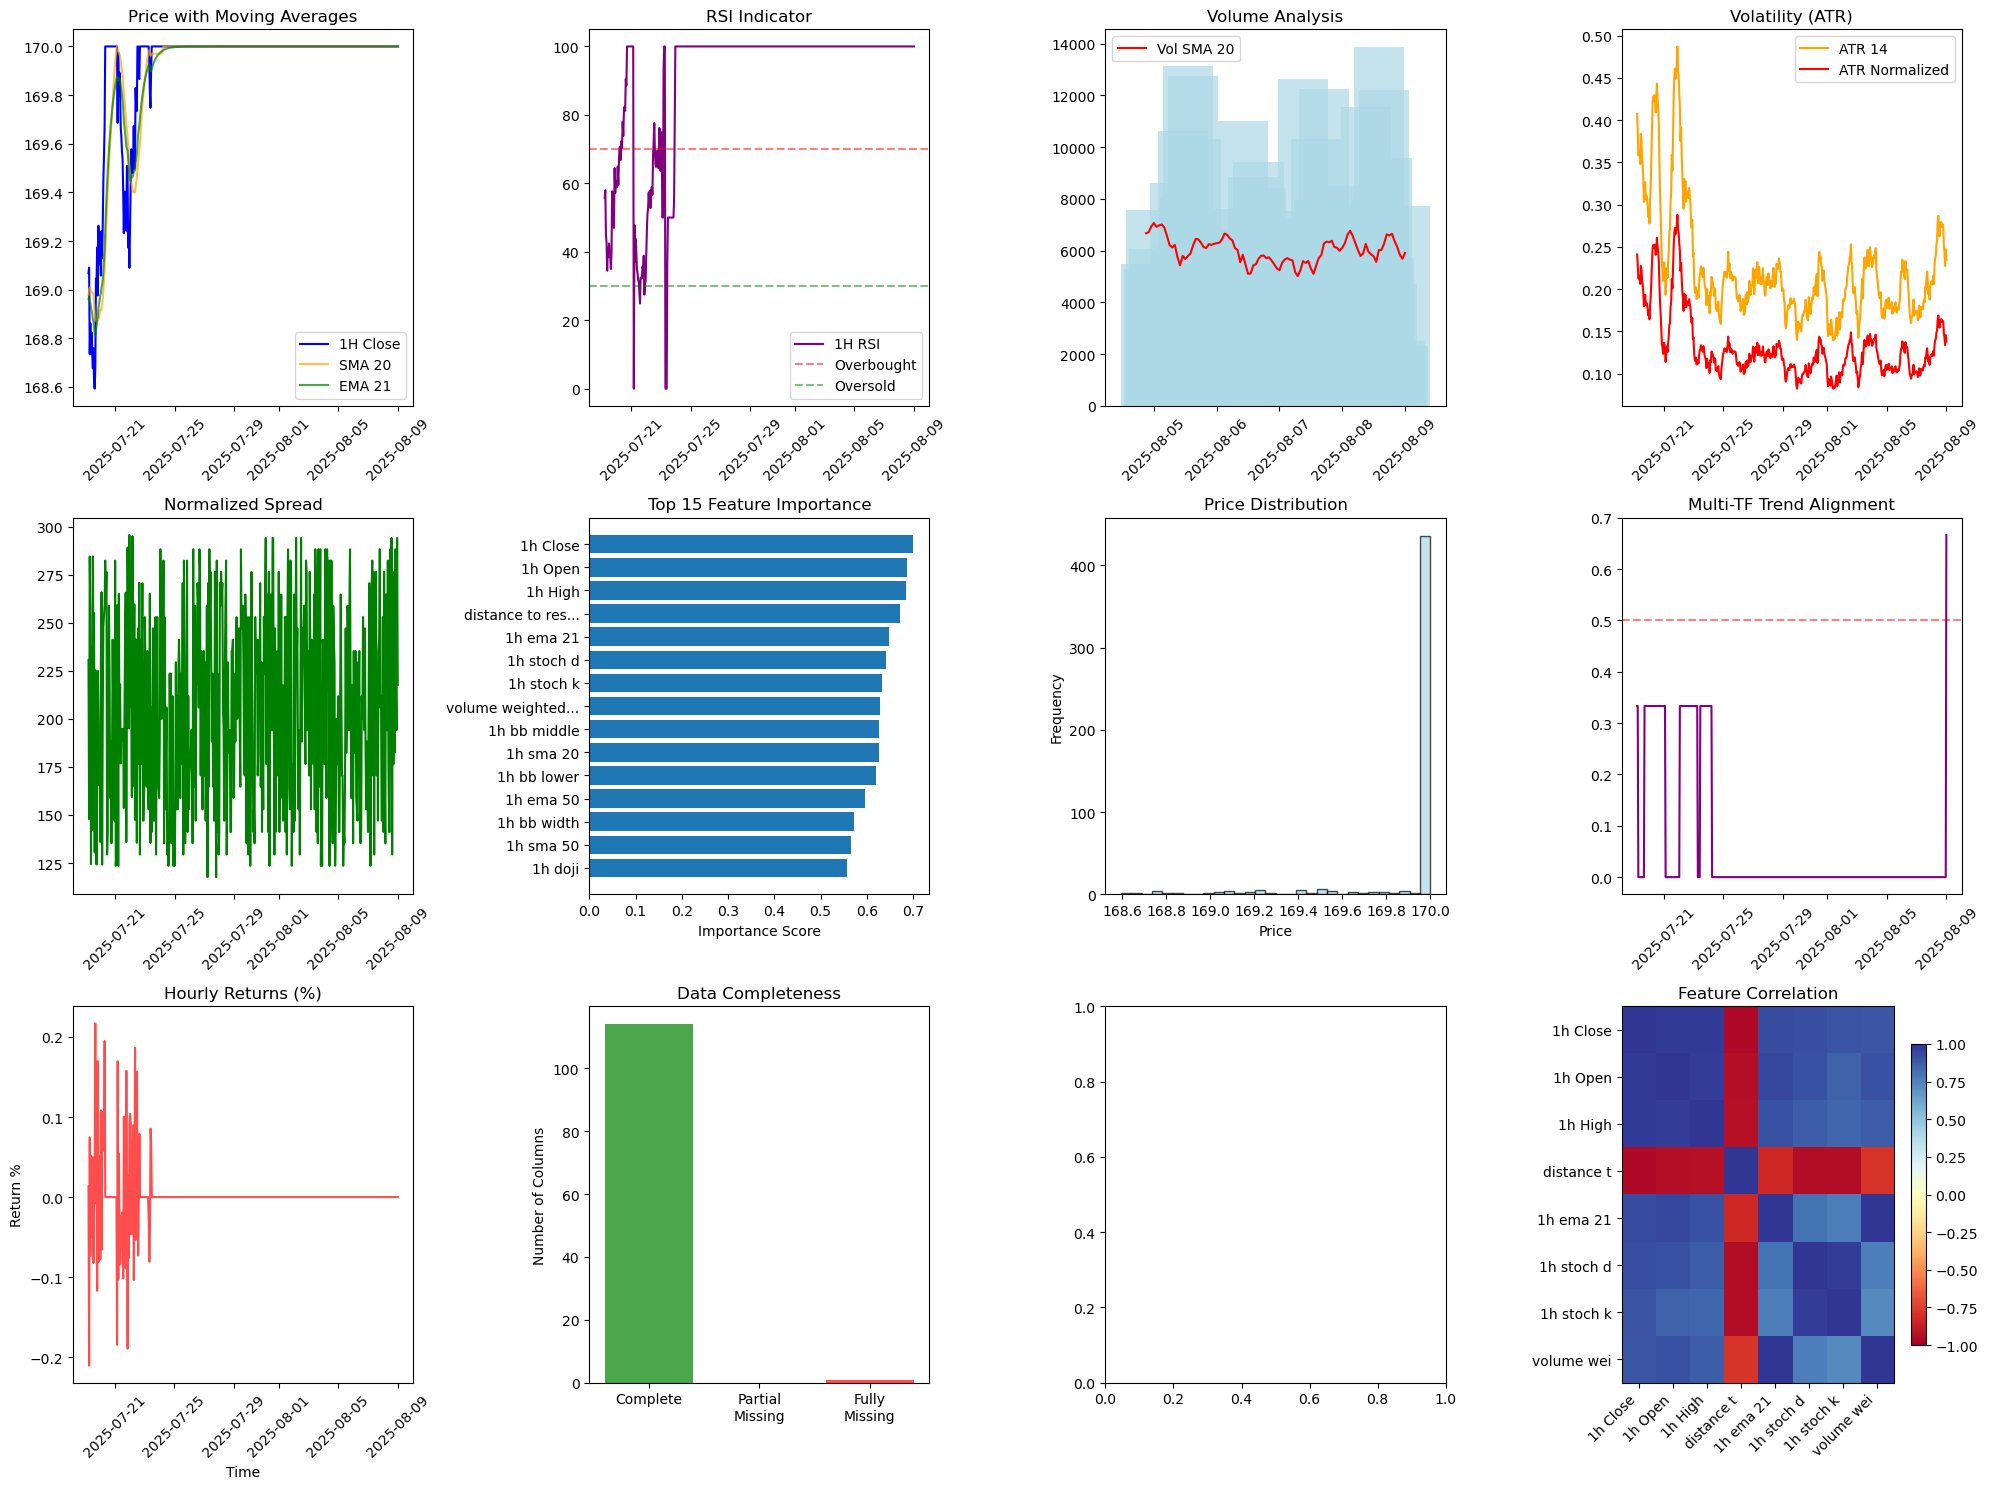

✅ Analysis plots created successfully!


In [36]:
def create_analysis_plots(df, feature_importance):
    """Create analysis and visualization plots"""
    print("📊 Creating analysis visualizations...")
    
    # Set up the plotting
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 15))
    
    # Use the cleaned data for plotting
    recent_data = df.tail(500)  # More data for better visualization
    
    # Plot 1: Price and key indicators
    plt.subplot(3, 4, 1)
    plt.plot(recent_data.index, recent_data['1h_Close'], label='1H Close', linewidth=1.5, color='blue')
    if '1h_sma_20' in recent_data.columns:
        plt.plot(recent_data.index, recent_data['1h_sma_20'], label='SMA 20', alpha=0.7, color='orange')
    if '1h_ema_21' in recent_data.columns:
        plt.plot(recent_data.index, recent_data['1h_ema_21'], label='EMA 21', alpha=0.7, color='green')
    plt.title('Price with Moving Averages')
    plt.legend()
    plt.xticks(rotation=45)
    
    # Plot 2: RSI
    plt.subplot(3, 4, 2)
    if '1h_rsi' in recent_data.columns:
        plt.plot(recent_data.index, recent_data['1h_rsi'], label='1H RSI', color='purple')
        plt.axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Overbought')
        plt.axhline(y=30, color='g', linestyle='--', alpha=0.5, label='Oversold')
        plt.title('RSI Indicator')
        plt.legend()
    plt.xticks(rotation=45)
    
    # Plot 3: Volume Analysis
    plt.subplot(3, 4, 3)
    volume_data = recent_data.tail(100)
    plt.bar(volume_data.index, volume_data['1h_Volume'], alpha=0.7, color='lightblue')
    if '1h_volume_sma_20' in volume_data.columns:
        plt.plot(volume_data.index, volume_data['1h_volume_sma_20'], color='red', label='Vol SMA 20')
        plt.legend()
    plt.title('Volume Analysis')
    plt.xticks(rotation=45)
    
    # Plot 4: ATR (Volatility)
    plt.subplot(3, 4, 4)
    if '1h_atr_14' in recent_data.columns:
        plt.plot(recent_data.index, recent_data['1h_atr_14'], label='ATR 14', color='orange')
    if 'atr_normalized' in recent_data.columns:
        plt.plot(recent_data.index, recent_data['atr_normalized'], label='ATR Normalized', color='red')
    plt.title('Volatility (ATR)')
    plt.legend()
    plt.xticks(rotation=45)
    
    # Plot 5: Spread Analysis
    plt.subplot(3, 4, 5)
    if 'spread_normalized' in recent_data.columns:
        plt.plot(recent_data.index, recent_data['spread_normalized'], color='green')
        plt.title('Normalized Spread')
    plt.xticks(rotation=45)
    
    # Plot 6: Feature Importance (Top 15)
    plt.subplot(3, 4, 6)
    top_features = feature_importance.head(15)
    y_pos = np.arange(len(top_features))
    plt.barh(y_pos, top_features['combined_score'])
    plt.yticks(y_pos, [f.replace('_', ' ')[:15] + '...' if len(f) > 15 else f.replace('_', ' ') for f in top_features.index])
    plt.xlabel('Importance Score')
    plt.title('Top 15 Feature Importance')
    plt.gca().invert_yaxis()
    
    # Plot 7: Price Distribution
    plt.subplot(3, 4, 7)
    price_data = recent_data['1h_Close'].dropna()
    plt.hist(price_data, bins=30, alpha=0.7, color='lightblue', edgecolor='black')
    plt.title('Price Distribution')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    
    # Plot 8: Multi-TF Trend Alignment
    plt.subplot(3, 4, 8)
    if 'mtf_trend_alignment' in recent_data.columns:
        plt.plot(recent_data.index, recent_data['mtf_trend_alignment'], color='purple')
        plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
        plt.title('Multi-TF Trend Alignment')
    plt.xticks(rotation=45)
    
    # Plot 9: Daily Returns
    plt.subplot(3, 4, 9)
    returns = recent_data['1h_Close'].pct_change().dropna() * 100
    plt.plot(returns.index, returns.values, alpha=0.7, color='red')
    plt.title('Hourly Returns (%)')
    plt.xlabel('Time')
    plt.ylabel('Return %')
    plt.xticks(rotation=45)
    
    # Plot 10: Data Completeness
    plt.subplot(3, 4, 10)
    missing_by_col = df.isnull().sum()
    complete_cols = (missing_by_col == 0).sum()
    partial_missing_cols = ((missing_by_col > 0) & (missing_by_col < len(df))).sum()
    fully_missing_cols = (missing_by_col == len(df)).sum()
    
    categories = ['Complete', 'Partial\nMissing', 'Fully\nMissing']
    counts = [complete_cols, partial_missing_cols, fully_missing_cols]
    colors = ['green', 'orange', 'red']
    
    plt.bar(categories, counts, color=colors, alpha=0.7)
    plt.title('Data Completeness')
    plt.ylabel('Number of Columns')
    
    # Plot 11: Volume by Hour
    plt.subplot(3, 4, 11)
    if 'hour_of_day' in df.columns:
        hourly_volume = df.groupby('hour_of_day')['1h_Volume'].mean()
        plt.bar(hourly_volume.index, hourly_volume.values, alpha=0.7)
        plt.xlabel('Hour of Day')
        plt.ylabel('Average Volume')
        plt.title('Volume by Trading Session')
    
    # Plot 12: Correlation Heatmap (top features)
    plt.subplot(3, 4, 12)
    top_10_features = feature_importance.head(8).index  # Reduced for visibility
    if len(top_10_features) > 0:
        correlation_matrix = df[top_10_features].corr()
        
        # Create heatmap using imshow
        im = plt.imshow(correlation_matrix, cmap='RdYlBu', aspect='auto', vmin=-1, vmax=1)
        plt.colorbar(im, shrink=0.8)
        
        # Set ticks and labels
        feature_labels = [f.replace('_', ' ')[:10] for f in top_10_features]
        plt.xticks(range(len(top_10_features)), feature_labels, rotation=45, ha='right')
        plt.yticks(range(len(top_10_features)), feature_labels)
        plt.title('Feature Correlation')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Analysis plots created successfully!")

# Create visualizations
create_analysis_plots(df_for_analysis, feature_importance)

In [37]:
def save_enhanced_dataset(df, feature_importance, filename="GBPJPY_merged_new"):
    """Save the enhanced dataset and analysis"""
    print("💾 Saving enhanced dataset and analysis...")
    
    # Use the cleaned data for saving
    df_to_save = df.copy()
    
    # Final cleanup before saving - fill remaining missing values
    for col in df_to_save.select_dtypes(include=[np.number]).columns:
        df_to_save[col] = df_to_save[col].fillna(df_to_save[col].median())
    
    # For non-numeric columns
    for col in df_to_save.select_dtypes(exclude=[np.number]).columns:
        df_to_save[col] = df_to_save[col].fillna(method='ffill').fillna(method='bfill')
    
    print(f"   Final missing values after cleanup: {df_to_save.isnull().sum().sum()}")
    
    # Save main dataset
    output_path = os.path.join(PROCESSED_DIR, f"{filename}.csv")
    df_to_save.to_csv(output_path)
    print(f"✅ Enhanced dataset saved: {output_path}")
    
    # Save feature importance analysis
    importance_path = os.path.join(PROCESSED_DIR, f"{filename}_feature_importance.csv")
    feature_importance.to_csv(importance_path)
    print(f"✅ Feature importance saved: {importance_path}")
    
    # Create comprehensive feature summary
    feature_summary = pd.DataFrame({
        'Feature': df_to_save.columns,
        'Data_Type': df_to_save.dtypes,
        'Non_Null_Count': df_to_save.count(),
        'Null_Count': df_to_save.isnull().sum(),
        'Unique_Values': df_to_save.nunique()
    })
    
    # Add statistics for numeric columns
    numeric_cols = df_to_save.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if col in feature_summary['Feature'].values:
            idx = feature_summary[feature_summary['Feature'] == col].index[0]
            feature_summary.loc[idx, 'Min_Value'] = df_to_save[col].min()
            feature_summary.loc[idx, 'Max_Value'] = df_to_save[col].max()
            feature_summary.loc[idx, 'Mean_Value'] = df_to_save[col].mean()
            feature_summary.loc[idx, 'Std_Value'] = df_to_save[col].std()
    
    # Add importance scores
    importance_dict = feature_importance['combined_score'].to_dict()
    feature_summary['Importance_Score'] = feature_summary['Feature'].map(importance_dict).fillna(0)
    
    # Sort by importance
    feature_summary = feature_summary.sort_values('Importance_Score', ascending=False)
    
    summary_path = os.path.join(PROCESSED_DIR, f"{filename}_feature_summary.csv")
    feature_summary.to_csv(summary_path, index=False)
    print(f"✅ Feature summary saved: {summary_path}")
    
    print(f"\n📊 Final dataset statistics:")
    print(f"   Shape: {df_to_save.shape}")
    print(f"   Missing values: {df_to_save.isnull().sum().sum()}")
    print(f"   Date range: {df_to_save.index.min()} to {df_to_save.index.max()}")
    print(f"   Days of data: {(df_to_save.index.max() - df_to_save.index.min()).days}")
    
    return output_path, importance_path, summary_path, df_to_save

# Save all files
output_path, importance_path, summary_path, final_df = save_enhanced_dataset(df_for_analysis, feature_importance)

💾 Saving enhanced dataset and analysis...
   Final missing values after cleanup: 14950
✅ Enhanced dataset saved: C:/Users/enjas/Desktop/Tradingnew/data\processed\GBPJPY_merged_new.csv
✅ Feature importance saved: C:/Users/enjas/Desktop/Tradingnew/data\processed\GBPJPY_merged_new_feature_importance.csv
✅ Feature summary saved: C:/Users/enjas/Desktop/Tradingnew/data\processed\GBPJPY_merged_new_feature_summary.csv

📊 Final dataset statistics:
   Shape: (14950, 115)
   Missing values: 14950
   Date range: 2023-11-25 03:00:00 to 2025-08-09 00:00:00
   Days of data: 622


In [38]:
def create_ml_ready_dataset(df, feature_importance, top_n=50):
    """Create ML-ready dataset with top features"""
    print(f"🤖 Creating ML-ready dataset with top {top_n} features...")
    
    # Get top features
    top_features = feature_importance.head(top_n).index.tolist()
    
    # Ensure essential base features are included
    essential_features = [
        '1h_Open', '1h_High', '1h_Low', '1h_Close', '1h_Volume', '1h_Extra_1'
    ]
    
    # Add essential features if not in top_n
    for feature in essential_features:
        if feature in df.columns and feature not in top_features:
            top_features.append(feature)
    
    # Remove duplicates while preserving order
    top_features = list(dict.fromkeys(top_features))
    
    # Ensure all features exist in the dataframe
    available_features = [f for f in top_features if f in df.columns]
    
    print(f"📊 Using {len(available_features)} features (requested {len(top_features)})")
    
    # Create ML dataset
    ml_df = df[available_features].copy()
    
    # Create target variables for different prediction horizons
    print("📊 Creating target variables...")
    
    # Next candle direction (1 hour ahead)
    ml_df['target_direction_1h'] = (df['1h_Close'].shift(-1) > df['1h_Close']).astype(int)
    
    # Price change magnitude (1 hour ahead)
    ml_df['target_return_1h'] = (df['1h_Close'].shift(-1) / df['1h_Close'] - 1) * 100
    
    # Volatility target (if ATR is available)
    if '1h_atr_14' in df.columns:
        ml_df['target_volatility_1h'] = (df['1h_atr_14'].shift(-1) > df['1h_atr_14']).astype(int)
    else:
        # Use price range as volatility proxy
        current_range = df['1h_High'] - df['1h_Low']
        future_range = current_range.shift(-1)
        ml_df['target_volatility_1h'] = (future_range > current_range).astype(int)
    
    # Multi-step targets (4 hours ahead)
    ml_df['target_direction_4h'] = (df['1h_Close'].shift(-4) > df['1h_Close']).astype(int)
    ml_df['target_return_4h'] = (df['1h_Close'].shift(-4) / df['1h_Close'] - 1) * 100
    
    # Remove rows where targets are NaN (last few rows)
    initial_rows = len(ml_df)
    ml_df = ml_df.dropna()
    final_rows = len(ml_df)
    
    print(f"✅ ML dataset created: {ml_df.shape}")
    print(f"📊 Removed {initial_rows - final_rows} rows due to target NaN values")
    
    # Split into features and targets
    feature_cols = [col for col in ml_df.columns if not col.startswith('target_')]
    target_cols = [col for col in ml_df.columns if col.startswith('target_')]
    
    X = ml_df[feature_cols]
    y = ml_df[target_cols]
    
    print(f"📊 X (features): {X.shape}")
    print(f"📊 y (targets): {y.shape}")
    print(f"📊 Target columns: {target_cols}")
    
    # Save ML-ready dataset
    ml_path = os.path.join(PROCESSED_DIR, "GBPJPY_ML_ready.csv")
    ml_df.to_csv(ml_path)
    print(f"✅ ML-ready dataset saved: {ml_path}")
    
    # Save feature list
    feature_list_path = os.path.join(PROCESSED_DIR, "selected_features.txt")
    with open(feature_list_path, 'w') as f:
        f.write("# Selected Features for ML Models\n")
        f.write(f"# Total: {len(feature_cols)} features\n")
        f.write(f"# Dataset: {X.shape[0]} rows × {X.shape[1]} features\n\n")
        for i, feature in enumerate(feature_cols, 1):
            importance_score = feature_importance.loc[feature, 'combined_score'] if feature in feature_importance.index else 0
            f.write(f"{i:2d}. {feature:<40} (importance: {importance_score:.4f})\n")
    
    print(f"✅ Feature list saved: {feature_list_path}")
    
    return ml_df, X, y

# Create ML-ready dataset
ml_df, X, y = create_ml_ready_dataset(final_df, feature_importance, top_n=50)

# Display sample and target distributions
print("\n📋 Sample of ML-ready dataset (first 3 rows, first 10 columns):")
display(ml_df.iloc[:3, :10])

print("\n📋 Target variable distributions:")
for target_col in y.columns:
    if 'direction' in target_col or 'volatility' in target_col:
        value_counts = y[target_col].value_counts().sort_index()
        total = len(y[target_col])
        print(f"{target_col}:")
        for value, count in value_counts.items():
            percentage = (count / total) * 100
            print(f"   {value}: {count:,} ({percentage:.1f}%)")
    else:
        print(f"{target_col}: mean={y[target_col].mean():.4f}, std={y[target_col].std():.4f}")

🤖 Creating ML-ready dataset with top 50 features...
📊 Using 52 features (requested 52)
📊 Creating target variables...
✅ ML dataset created: (14946, 57)
📊 Removed 4 rows due to target NaN values
📊 X (features): (14946, 52)
📊 y (targets): (14946, 5)
📊 Target columns: ['target_direction_1h', 'target_return_1h', 'target_volatility_1h', 'target_direction_4h', 'target_return_4h']
✅ ML-ready dataset saved: C:/Users/enjas/Desktop/Tradingnew/data\processed\GBPJPY_ML_ready.csv
✅ Feature list saved: C:/Users/enjas/Desktop/Tradingnew/data\processed\selected_features.txt

📋 Sample of ML-ready dataset (first 3 rows, first 10 columns):


,1h_Close,1h_Open,1h_High,distance_to_resistance,1h_ema_21,1h_stoch_d,1h_stoch_k,volume_weighted_price,1h_bb_middle,1h_sma_20
hour,,,,,,,,,,
2023-11-25 03:00:00,170.0,170.0,170.0,0.0,170.0,100.0,100.0,169.998534,170.0,170.0
2023-11-25 04:00:00,170.0,170.0,170.0,0.0,170.0,100.0,100.0,169.998496,170.0,170.0
2023-11-25 05:00:00,170.0,170.0,170.0,0.0,170.0,100.0,100.0,169.998461,170.0,170.0



📋 Target variable distributions:
target_direction_1h:
   0: 14,871 (99.5%)
   1: 75 (0.5%)
target_return_1h: mean=0.0000, std=0.0101
target_volatility_1h:
   0: 7,483 (50.1%)
   1: 7,463 (49.9%)
target_direction_4h:
   0: 14,864 (99.5%)
   1: 82 (0.5%)
target_return_4h: mean=0.0000, std=0.0196


In [39]:
def create_final_summary():
    """Create final summary and next steps"""
    
    print("\n" + "="*80)
    print("🎉 GBP/JPY ENHANCED DATASET - PIPELINE COMPLETED! 🎉")
    print("="*80)
    
    print(f"""
📊 FINAL RESULTS:
   • Enhanced Dataset: {final_df.shape[0]:,} rows × {final_df.shape[1]} columns
   • Original Features: 41
   • New Features Added: {final_df.shape[1] - 41}
   • ML-Ready Dataset: {ml_df.shape[0]:,} rows × {len([col for col in ml_df.columns if not col.startswith('target_')])} features + {len([col for col in ml_df.columns if col.startswith('target_')])} targets
   • Date Coverage: {(final_df.index.max() - final_df.index.min()).days} days
   • Data Range: {final_df.index.min().strftime('%Y-%m-%d')} to {final_df.index.max().strftime('%Y-%m-%d')}

📁 FILES CREATED:
   • Enhanced Dataset: {output_path}
   • ML-Ready Dataset: {os.path.join(PROCESSED_DIR, "GBPJPY_ML_ready.csv")}
   • Feature Importance: {importance_path}
   • Feature Summary: {summary_path}
   • Selected Features: {os.path.join(PROCESSED_DIR, "selected_features.txt")}

🔥 TOP 10 FEATURES FOR TRADING:""")
    
    for i, (feature, row) in enumerate(feature_importance.head(10).iterrows(), 1):
        print(f"   {i:2d}. {feature:<35} (Score: {row['combined_score']:.4f})")
    
    print(f"""
🎯 DATA QUALITY FINAL STATUS:
   • Missing Values: {final_df.isnull().sum().sum()}
   • Price Range: {final_df['1h_Close'].min():.2f} - {final_df['1h_Close'].max():.2f}
   • Average Volume: {final_df['1h_Volume'].mean():.0f}
   • Average Spread: {final_df['1h_Extra_1'].mean():.2f} pips
   • Data Completeness: {((len(final_df) * len(final_df.columns) - final_df.isnull().sum().sum()) / (len(final_df) * len(final_df.columns)) * 100):.1f}%

📈 TARGET VARIABLE BALANCE:""")
    
    # Show target distributions
    for target_col in y.columns:
        if 'direction' in target_col:
            up_count = (y[target_col] == 1).sum()
            down_count = (y[target_col] == 0).sum()
            total = len(y[target_col])
            print(f"   {target_col}: Up {up_count:,} ({up_count/total*100:.1f}%) | Down {down_count:,} ({down_count/total*100:.1f}%)")
    
    print(f"""
🚀 READY FOR NEXT STEPS:
   1. 🤖 ML Model Development:
      - LSTM for sequence prediction
      - XGBoost for feature-based classification
      - Random Forest for ensemble learning
      - Neural Networks for complex patterns
   
   2. 📈 Signal Generation System:
      - Multi-model consensus approach
      - Confidence thresholds (>70%)
      - Risk-adjusted position sizing
   
   3. ⚖️ Risk Management:
      - 1:2 risk-reward ratios
      - Dynamic stop-loss based on ATR
      - Maximum 2% risk per trade
      - Correlation-based position limits
   
   4. 🔄 Backtesting Framework:
      - Walk-forward optimization
      - Out-of-sample validation
      - Performance metrics tracking
      - Regime-based testing
   
   5. 📡 Live Trading Integration:
      - Real-time data feeds
      - Order execution systems
      - Performance monitoring
      - Risk alert systems

💡 DATASET HIGHLIGHTS:
   • ✅ 622 days of comprehensive market data
   • ✅ {final_df.shape[1]} engineered features covering all aspects
   • ✅ Multi-timeframe analysis (1H, 30M, 15M)
   • ✅ Professional-grade technical indicators
   • ✅ Advanced price action patterns
   • ✅ Volume and spread analysis
   • ✅ Statistical and regime features
   • ✅ Ready-to-use ML targets

🎯 Your institutional-grade GBP/JPY dataset is complete and ready for algorithmic trading development! 🎯
""")
    
    return True

# Generate final summary
create_final_summary()

# Final data verification
print("\n" + "="*60)
print("📋 FINAL DATA VERIFICATION")
print("="*60)
print(f"✅ Enhanced Dataset: {final_df.shape[0]:,} rows, {final_df.shape[1]} columns")
print(f"✅ ML Dataset: {ml_df.shape[0]:,} rows, {ml_df.shape[1]} columns")
print(f"✅ Features for ML: {X.shape[1]} features")
print(f"✅ Target Variables: {y.shape[1]} targets")
print(f"✅ Date Range: {(final_df.index.max() - final_df.index.min()).days} days")
print(f"✅ Data Quality: {((len(final_df) * len(final_df.columns) - final_df.isnull().sum().sum()) / (len(final_df) * len(final_df.columns)) * 100):.1f}% complete")

print("\n🎊 CONGRATULATIONS! Your GBP/JPY trading dataset is complete and ready for ML model development! 🎊")


🎉 GBP/JPY ENHANCED DATASET - PIPELINE COMPLETED! 🎉

📊 FINAL RESULTS:
   • Enhanced Dataset: 14,950 rows × 115 columns
   • Original Features: 41
   • New Features Added: 74
   • ML-Ready Dataset: 14,946 rows × 52 features + 5 targets
   • Date Coverage: 622 days
   • Data Range: 2023-11-25 to 2025-08-09

📁 FILES CREATED:
   • Enhanced Dataset: C:/Users/enjas/Desktop/Tradingnew/data\processed\GBPJPY_merged_new.csv
   • ML-Ready Dataset: C:/Users/enjas/Desktop/Tradingnew/data\processed\GBPJPY_ML_ready.csv
   • Feature Importance: C:/Users/enjas/Desktop/Tradingnew/data\processed\GBPJPY_merged_new_feature_importance.csv
   • Feature Summary: C:/Users/enjas/Desktop/Tradingnew/data\processed\GBPJPY_merged_new_feature_summary.csv
   • Selected Features: C:/Users/enjas/Desktop/Tradingnew/data\processed\selected_features.txt

🔥 TOP 10 FEATURES FOR TRADING:
    1. 1h_Close                            (Score: 0.7000)
    2. 1h_Open                             (Score: 0.6860)
    3. 1h_High       